# Preamble

TODO

## Setup
### Imports



In [1]:
import itertools
import unicodedata
import re
import os
from pathlib import Path
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
import matplotlib
from  matplotlib.ticker import FuncFormatter
import networkx as nx

### Helper Functions

In [2]:
def flatmap(func, *iterable):
    return itertools.chain.from_iterable(map(func, *iterable))

In [3]:
def contingency_statistics(contingency):
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency)
    association = scipy.stats.contingency.association(contingency)
    return {
        "χ²": chi2,
        "p-value": p,
        "DOF": dof,
        "V": association
    }


### Style

We configure a heatmap/colour scheme for tables, set a theme for plots and configure the numbers to conform to German customs.

In [4]:
if "ANTINOOU_FONT" in os.environ:
    matplotlib.font_manager.fontManager.addfont(os.environ["ANTINOOU_FONT"])

cm = plt.cm.Blues
sns.set_style("whitegrid")
pd.set_option("styler.format.decimal", ",")
pd.set_option("styler.format.precision", 1)
pd.set_option("styler.format.na_rep", "–")
matplotlib.rcParams['font.family'] = ['Antinoou', 'serif']

### Assets Export

Finally, we want to set up functions for writing tables and figures to external files, so they can be included in a document.

In [5]:
subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.pdf")


def write_csv(df, the_name):
    df.to_csv(subdirectory / (the_name + '.csv'))  

def write_table(df, the_name, caption="", heatmap=False, as_ints=False, axis=None):
    style = df.style.format(precision=0, na_rep="–") if as_ints else df.style
    style = style if not heatmap else style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

### Greek/Coptic Alphabet
We also define a table mapping Unicode Greek letters to Unicode Coptic letters.
See [here](#greek-transliteration) for more info.

In [6]:
greek_to_coptic = {
  'α': 'ⲁ',
  'β': 'ⲃ',
  'γ': 'ⲅ', 
  'δ': 'ⲇ',
  'ε': 'ⲉ',
  'ζ': 'ⲍ',
  'η': 'ⲏ',
  'θ': 'ⲑ',
  'ϑ': 'ⲑ',
  'ι': 'ⲓ',
  'κ': 'ⲕ',
  'λ': 'ⲗ',
  'μ': 'ⲙ',
  'ν': 'ⲛ',
  'ξ': 'ⲝ',
  'ο': 'ⲟ',
  'π': 'ⲡ',
  'ρ': 'ⲣ',
  'σ': 'ⲥ',
  'τ': 'ⲧ',
  'υ': 'ⲩ',
  'φ': 'ⲫ',
  'χ': 'ⲭ',
  'ψ': 'ⲯ',
  'ω': 'ⲱ',
  'ς': 'ⲥ',
  'ϗ': 'ⳤ',
  '\u0314': 'ϩ',
  '\u0345': 'ⲓ',
}

consonants = set("ⲡ ⲧ ⲕ ⲃ ⲇ ⲅ ⲫ ⲑ ⲭ ϩ ⲥ ϣ ϥ ϫ ϭ ⲗ ⲣ ⳉ ϧ ⲛ ⲙ ⲍ ⲝ ⲯ".split())

vowels = set("ⲁ ⲉ ⲏ ⲓ ⲟ ⲱ ⲩ".split())

diphthongs = set("ⲁⲓ ⲉⲓ ⲏⲓ ⲟⲓ ⲩⲓ ⲱⲓ ⲁⲩ ⲉⲩ ⲟⲩ ⲏⲩ".split())

greek_to_coptic_ord = {ord(greek): ord(coptic) for greek, coptic in greek_to_coptic.items()}

# Data Processing

## Importing the Data
The CSV file we are going to use contains a large corpus of Greek words and their concrete spellings within Coptic texts, about 200K occurrences.

In [7]:
df = pd.read_csv(os.getenv("ATTESTATIONS_CSV")) \
    .set_index("id") \
    .drop(columns=["dialect"]) \
    .rename(columns={"code": "dialect"})

/tmp/ipykernel_742512/345480005.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.getenv("ATTESTATIONS_CSV")) \


Here are some random examples of these data points:

In [8]:
dialects = ["B", "F", "M", "S", "L", "A"]
df["dialect_group"] = pd.Categorical(df["dialect_group"].replace({
    "Akhmimic Dialects": "A",
    "Lycopolitan Dialects": "L",
    "Middle Egyptian Dialects": "M",
    "Sahidic Dialects": "S",
    "Bohairic Dialects": "B",
    "Fayyumic Dialects": "F"
}), dialects)

In [9]:
df.sample(5)

,quote_coptic,quote_english,orthography,encoding,coptic_lemma_id,coptic_lemma,coptic_lemma2,greek_lemma_id,greek_lemma,edition,manuscript_text,earliest,latest,?,collection,material,dialectCode,dialect_group,dialect,name
id,,,,,,,,,,,,,,,,,,,,
11098,^ⲙⲏ^ ⲁⲕⲟⲩⲉϣ ϩⲁ|ⲧⲃⲉⲧ ϩⲱ,Do you want to kill me.too^?^,ⲙⲏ,1fun-ind.2prs.cnstA,1621,ⲙⲏ,ⲙⲏ,1408,μή,Schenke 1991a,New York - The Morgan Library and Museum G.67 ...,400.0,499.0,NaN,New York - The Morgan Library and Museum G.67,Parchment,M,M,M,Mesokemic
34093,ⲁϥϭⲓ ⲛ̄ⲛⲓⲙⲉⲣⲟⲥ ⲉ̄ⲧⲁⲩⲕⲱϣ ⲛ̄ϫⲉ \ ⲁ̄ⲡⲁ ⲧⲏⲣ ⲁϥⲉⲣ^ⲥ...,Apa Ter took the pieces that had been broken.[...,ⲥⲫⲣⲁⲅⲓⲍⲓⲛ,vb.1prf.auxy.ob1.obn,2965,ⲥⲫⲣⲁⲅⲓⲍⲓⲛ,ⲥⲫⲣⲁⲅⲓⲍⲓⲛ,2596,σφραγίζω,Hyvernat 1977,Rome - Vatican - Biblioteca del Vaticano Vat. ...,800.0,1099.0,NaN,Rome - Vatican - Biblioteca del Vaticano Vat. ...,Parchment,B,B,B,Bohairic
109811,ⲡⲉⲧⲣⲟⲥ ⲙⲉⲛ ^ⲟⲩⲛ^ ⲛⲁⲩⲁⲣⲉϩ ⲉⲣⲟϥ ϧⲉⲛ ⲡⲓϣⲧⲉⲕⲟ ⲛⲁⲥⲉ...,NaN,ⲟⲩⲛ,NaN,1803,ⲟⲩⲛ,ⲟⲩⲛ,1597,οὖν,S. G. Richter 2014,INTF Acta* (bohairic) - Acts of the Apostles,NaN,NaN,NaN,INTF Acta* (bohairic),NaN,B,B,B,Bohairic
161913,[.[].] | ϩⲛ ⲧⲉϥⲁⲣⲭⲏ · ⲁⲩ̣[.[].] | ⲛϥⲃⲟⲗⲥ̄ ⲉⲃⲟⲗ...,NaN,ⲕⲁⲓⲣⲟⲥ,nn.m.sg.dtd,1150,ⲕⲁⲓⲣⲟⲥ,ⲕⲁⲓⲣⲟⲥ,994,καιρός,Jernstedt 1959,Moscow - Pushkin Museum I.1.b.547 - P.MoscowCo...,200.0,1119.0,NaN,Moscow - Pushkin Museum I.1.b.547,Unknown,S,S,S,Sahidic
170428,ⲁⲕⲱⲥⲧⲁⲛⲧⲓ̈ⲛⲟⲥ ϫⲓ̈ ⲙ̄ⲡⲉϫⲣⲟ ⸳ ⲛ̄ⲧⲉⲣⲉϥ^ⲡⲓ̈ⲥ|ⲧⲉⲩⲉ^...,NaN,ⲡⲓ̈ⲥ|ⲧⲉⲩⲉ,vb.tmp.auxn.ob2,1954,ⲡⲓⲥⲧⲉⲩⲉ,ⲡⲓⲥⲧⲉⲩⲉ,1744,πιστεύω,Cramer/Krause 2008,New York - The Morgan Library and Museum M575 ...,875.0,899.0,892-893,New York - The Morgan Library and Museum M575,Parchment,S,S,S,Sahidic


## Exploring the Data

### Dates of the Texts
The data points originate from texts scattered across multiple centuries.
These are the texts, together with a plausible date range (if available):

In [10]:
df[["manuscript_text", "earliest", "latest"]].set_index("manuscript_text").drop_duplicates()

,earliest,latest
manuscript_text,,
Cambridge - Bible Society's Library pap. Q - Gospel of John,200.0,299.0
Papyrus Nag Hammadi C 002 - Genesis,200.0,399.0
London - British Library Or 4919(5) - Lamentations,NaN,NaN
Leipzig - Universität - Papyrus- und Ostrakasammlung P.Lips. Inv. 2299 - Exodus Apocryphon,200.0,499.0
Moscow - Pushkin Museum I.1.b.523 - P.MoscowCopt 90,200.0,1119.0
...,...,...
Berlin - Ägyptisches Museum P. 8324 - BKU I 18 (Healing amulet),NaN,699.0
London - British Library Or. 5525 - P.Lond.Copt. 1 524 (magical text to protect a woman and her children),NaN,899.0
London - British Library Or. 6800 - Colophon with prayer for Mena bishop of Keft,1000.0,1033.0


Because we may want to try to correlate some deviations in spelling with the time period at which they occur, we want to know how many texts lack a date (and therefore cannot be used for this analysis):

In [11]:
len(df[pd.isna(df["earliest"]) & pd.isna(df["latest"])]) / len(df)

0.4687119220970162

As we can see, almost half of the attestations of Greek words in Coptic texts lack a plausible date.
This leaves us with about 100K dateable data points, which should still be enough for robust analysis.

Since there are often two date series—an upper and a lower bound—and it is easier to work with only one series, we use the arithmetic mean of the latest and earliest dates if both are available, otherwise we use the one available date.

In [183]:
def unify_date(row):
    if not math.isnan(row["latest"]) and not math.isnan(row["earliest"]):
        return (row["latest"]+row["earliest"])/2
    elif not math.isnan(row["latest"]):
        return row["latest"]
    elif not math.isnan(row["earliest"]):
        return row["earliest"]
    else:
        return None

df["date_approximate"] = df.apply(unify_date, axis=1)

earliest_date = df["earliest"].min()
latest_date = df["latest"].max()

def get_date_range(row):
    if not math.isnan(row["latest"]) and not math.isnan(row["earliest"]):
        return (row["earliest"], row["latest"])
    elif not math.isnan(row["latest"]):
        return (earliest_date, row["latest"])
    elif not math.isnan(row["earliest"]):
        return (row["earliest"], latest_date)
    else:
        return (earliest_date, latest_date)

df["date_range"] = df.apply(get_date_range, axis=1)

We get the following distribution of attestations of Greek words in total:

<Axes: >

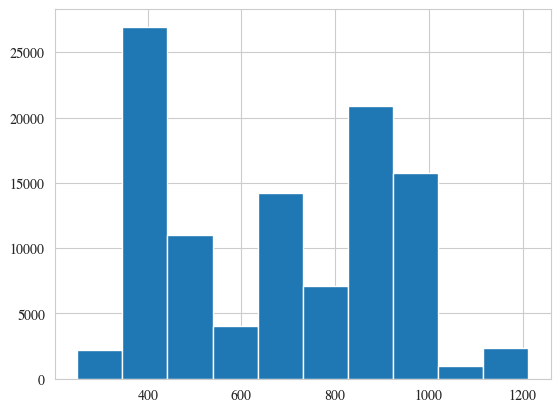

In [167]:
df["date_approximate"].hist()

In [184]:
def quartiles(series):
    sorted_series = series.sort_values()
    n = series.size
    return sorted_series[int(n * 0.25)], sorted_series[int(n * 0.50)], sorted_series[int(n * 0.75)]

quartiles(df["date_range"])

((375.0, 433.0), (200.0, 1299.0), (800.0, 899.0))

In [196]:
df["date_range"].sort_values()[150000:]

id
75869       (675.0, 699.0)
75848       (675.0, 699.0)
75847       (675.0, 699.0)
75846       (675.0, 699.0)
75845       (675.0, 699.0)
                ...       
25602     (1200.0, 1224.0)
25592     (1200.0, 1224.0)
198710    (1200.0, 1299.0)
198711    (1200.0, 1299.0)
198712    (1200.0, 1299.0)
Name: date_range, Length: 48606, dtype: object

In [168]:
df.groupby("dialect_group")["dialectCode"].value_counts()

/tmp/ipykernel_742512/2301519216.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("dialect_group")["dialectCode"].value_counts()


dialect_group  dialectCode
B              B              7735
               B4             1454
               *Fdoc             0
               A                 0
               F                 0
                              ... 
A              M5                0
               S                 0
               Sp                0
               V                 0
               W                 0
Name: count, Length: 126, dtype: int64

In [169]:
per_dialect = pd.DataFrame({
    "Gr. Tokens": df["dialect_group"].value_counts(),
    "Gr. Types": df.groupby("dialect_group")["greek_lemma"].unique().apply(len),
    "Texte": df.groupby("dialect_group")["manuscript_text"].unique().apply(len),
    "Datierung": df.groupby("dialect_group")["earliest"].min().astype(int).astype(str) + " – " + df.groupby("dialect_group")["latest"].max().astype(int).astype(str),
})#.sort_values(by="Gr. Tokens", ascending=False)
per_dialect.index = per_dialect.index.rename("Dialektgruppe")
write_table(per_dialect, "dialect-frequencies", caption="Häufigkeiten griechischer Lehnwörter nach Dialekt sowie Anzahl der Texte und ungefährer Belegzeitraum", heatmap=False, as_ints=False, axis=None)
per_dialect

/tmp/ipykernel_742512/4009314427.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Gr. Types": df.groupby("dialect_group")["greek_lemma"].unique().apply(len),
/tmp/ipykernel_742512/4009314427.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Texte": df.groupby("dialect_group")["manuscript_text"].unique().apply(len),
/tmp/ipykernel_742512/4009314427.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  "Datierung": df

,Gr. Tokens,Gr. Types,Texte,Datierung
Dialektgruppe,,,,
B,9189,1112,39,300 – 1249
F,3446,578,69,200 – 1199
M,8447,685,19,364 – 599
S,163466,4435,2963,200 – 1299
L,8462,959,130,200 – 499
A,5596,613,26,300 – 599


## Cleaning the Data
Next, it makes sense to strip some columns from the table. For our analysis of orthographical deviation, we only need the `orthography` and `greek_lemma` columns (for comparing them against each other).
For further analysis of factors such as date or dialect, we also keep the `dialect` column as well as our new `date_approximate` column.

In [170]:
df_simple = df[["orthography", "greek_lemma", "dialect_group", "date_approximate", "latest", "earliest", "date_range", "manuscript_text"]]

We also want to remove any rows which for some reason either lack an `orthography` or a `greek_lemma`. We need both for our analysis.

In [171]:
df_simple = df_simple.dropna(subset={"orthography", "greek_lemma"})

In [172]:
df_simple[df_simple["greek_lemma"].str.contains(r"ρρ", regex=True)].sample(10)

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text
id,,,,,,,,
88086,ⲑⲁⲣⲣⲉⲓ,θαρρέω,S,637.0,649.0,625.0,"[625.0, 649.0]",New York - Columbia University P.600 - SB Kopt...
192447,ⲃⲏⲣⲉ,βίρρος,S,699.5,799.0,600.0,"[600.0, 799.0]",Vienna - Nationalbibliothek K 1263 - CPR XII 1...
41066,ⲡⲁⲣⲣⲏⲥⲓ̈ⲁ̄,παρρησία,S,NaN,NaN,NaN,"[200.0, 1299.0]",New York - The Morgan Library and Museum M.593...
129231,ⲁⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"[200.0, 1299.0]",London - British Library Add MS 5114 - Pistis ...
129147,ⲁ\ⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"[200.0, 1299.0]",London - British Library Add MS 5114 - Pistis ...
3867,ⲡⲁⲣⲏⲥⲓⲁ,παρρησία,B,349.5,399.0,300.0,"[300.0, 399.0]",Geneva - Fondation Bodmer 3 - Gospel of John
129232,ⲁⲡⲟϩⲣⲟⲓⲁ,ἀπόρροια,S,NaN,NaN,NaN,"[200.0, 1299.0]",London - British Library Add MS 5114 - Pistis ...
110028,ⲡⲁⲣⲣⲏⲥⲓⲁ,παρρησία,B,NaN,NaN,NaN,"[200.0, 1299.0]",INTF Acta* (bohairic) - Acts of the Apostles
187246,ⲡⲁⲣϩⲏⲥⲓ̈ⲁ,παρρησία,S,987.0,999.0,975.0,"[975.0, 999.0]",New York - The Morgan Library and Museum M.633...


We also want to remove all rows which are explicitly marked as erroneous (via `sic`) or as abbreviations, i.e. ending with `/` or similar or containing `…` or other common abbreviation characters, e.g. monograms.

In [173]:
df_simple = df_simple[~(
    df_simple["orthography"].str.contains("sic")
    | df_simple["orthography"].str.endswith(("/", "/̅", "/°")) # remove marked abbreviations
    | df_simple["orthography"].str.contains("\d|[….ⳇ⁄?ⳁ⳨Ⳁ⳧ⲋ⳦⳥⳽]", regex=True) # remove lines with numbers or marked abbreviations
)]

The `orthography` column is still littered with all kinds of combining diacritics, letter variants, capital letters or Greek script that have crept in. We therefore create an `orthography_clean` column, applying the following transformations:

In [174]:
df_simple["orthography_clean"] = (
    df_simple["orthography"]
    .str.strip() # remove extraneous whitespace
    .str.lower() # convert capital letters to lower case
    .apply(lambda x: x.translate(greek_to_coptic_ord)) # convert Greek letters that crept in
    .str.replace("ϊ", "ⲓ") # convert precombined accented greek letter
    .str.replace("[\u0305\u0304\ufe24\ufe25\ufe26\u2cf1\u2cf0\u0300]+", "", regex=True) # remove overlines
    .str.replace("[\u2CBB\u2CEF]", "ⲛ", regex=True) # normalize letter ⲛ (written as stroke)
    .str.replace("[ⳅⲹ]", "ⲍ", regex=True) # normalize letter ⲍ
    .str.replace("o", "ⲟ") # replace latin o by coptic
    .str.replace("\u001D|\u0314|\u200E|\u0486|\u02BE|\u2CFF|\u0307|\u0308|\u0301|\u0323|\u0304|\u1DCD|\u0302|\u0306" + "|" + r"col\.b|/|⟦.*?⟧|\\|\[|\]|[‖|´⸤⸥⸢⸣⁅⁆⸖'‹›`’`´:⸌⸍\⸳‧·•·ʾ*]", "", regex=True)
)

By removing all expected alphabetic characters from the orthographies, we can see how many rows still contain unexpected characters:

In [175]:
df_simple["strange_characters"] = df_simple["orthography_clean"].str.replace("[ϯϫϭⲁⲃⲅⲇⲉⲍⲏⲑⲕⲗⲙⲛⲝⲡⲣⲥⲧⲟⲱⲩⲓϩⲫϣ ⲭⳉϥⲯⲡⳤ\u0305]", "", regex=True).apply(lambda x: set(c for c in x))
df_simple[df_simple["strange_characters"].apply(lambda x: len(x) > 0)]

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,date_range,manuscript_text,orthography_clean,strange_characters
id,,,,,,,,,,
98756,ⲡⲣⲏⲣ[ⲱ]ⲥⲓ̈[c],πλήρωσις,S,749.5,899.0,600.0,"[600.0, 899.0]",GIOV.AM - Homily on the Passion and the Resurr...,ⲡⲣⲏⲣⲱⲥⲓc,{c}
50102,~,στοιχέω,S,749.5,799.0,700.0,"[700.0, 799.0]",Cairo - Egyptian Museum CG 8281 - O.Crum 418,~,{~}
72021,ⲁⲗⲙⲟⲩⲡⲧⲱ‵ⲛ′,(incertum),S,899.5,999.0,800.0,"[800.0, 999.0]",Paris - Louvre AF 12530 - Medical precriptions...,ⲁⲗⲙⲟⲩⲡⲧⲱ‵ⲛ′,"{′, ‵}"
72466,ⲡⲉⲣ․ⲓⲭⲣⲓⲥⲙⲁ,περίχρισμα,S,899.5,999.0,800.0,"[800.0, 999.0]",Paris - Bibliothèque Nationale Copte 132.5.1 (...,ⲡⲉⲣ․ⲓⲭⲣⲓⲥⲙⲁ,{․}
77044,[I],(incertum),S,899.5,999.0,800.0,"[800.0, 999.0]",Cairo - IFAO P.No. unknown - P.Méd.Copt. IFAO ...,i,{i}
176829,ⲁⲉⲓ|[b]ⲧⲟⲥ,ἀετός,S,NaN,NaN,NaN,"[200.0, 1299.0]",New York - The Morgan Library and Museum M.583...,ⲁⲉⲓbⲧⲟⲥ,{b}
94989,ⲙⲁⲕ⸌+⸍,μακάριος,S,NaN,NaN,NaN,"[200.0, 1299.0]",Cairo - Egyptian Museum CG 8728 - P.KRU 106 (T...,ⲙⲁⲕ+,{+}
96126,N⸌ο⸍,νόμισμα,S,NaN,NaN,NaN,"[200.0, 1299.0]",London - British Library Or. 6721 (2) - P.KRU ...,nⲟ,{n}
96128,N⸌ο⸍,νόμισμα,S,NaN,NaN,NaN,"[200.0, 1299.0]",London - British Library Or. 6721 (2) - P.KRU ...,nⲟ,{n}


These remaining cases are neglegible.

In [22]:
df_simple.sample(10)

,orthography,greek_lemma,dialect_group,date_approximate,latest,earliest,orthography_clean,strange_characters
id,,,,,,,,
9222,ⲁⲣⲛⲓ,ἀρνέομαι,M,NaN,NaN,NaN,ⲁⲣⲛⲓ,{}
161872,ⲟⲩⲇⲉ,οὐδέ,S,NaN,NaN,NaN,ⲟⲩⲇⲉ,{}
45928,ⲭ︦ⲥ︦,χριστός,S,699.5,999.0,400.0,ⲭⲥ,{}
123011,ⲙⲁⲣⲧⲩⲣⲉⲓ,μαρτυρέω,S,NaN,NaN,NaN,ⲙⲁⲣⲧⲩⲣⲉⲓ,{}
131188,ⲯⲩ|ⲭⲏ,ψυχή,S,449.5,499.0,400.0,ⲯⲩⲭⲏ,{}
22403,ⲅⲁⲣ,γάρ,S,NaN,NaN,NaN,ⲅⲁⲣ,{}
75812,ⲫⲓⲁⲗⲓ,φιάλη,S,949.5,999.0,900.0,ⲫⲓⲁⲗⲓ,{}
162147,ⲇⲉ,δέ,S,NaN,NaN,NaN,ⲇⲉ,{}
39368,ⲉⲛⲉⲣⲅⲉⲓ,ἐνεργέω,S,NaN,NaN,NaN,ⲉⲛⲉⲣⲅⲉⲓ,{}


## Finding Deviations

TODO

<a id="greek-transliteration"></a>
### Transliteration from Greek to Coptic

In the following, we want to compare the (normative) Greek spelling to various actual Coptic spellings.
The Greek and Coptic alphabets are handled by Unicode differently, so trying to find the differences between a word such as δίκαιος and ⲇⲓⲕⲁⲓⲟⲥ
would highlight every letter as different, because the actual codepoints of the Greek and Coptic delta, iota etc. differ.
We therefore need to "transliterate" (using quotes, because the alphabets are essentially the same) either the Coptic words into the Greek alphabet or the Greek words into the Coptic.

Because the Coptic alphabet is a superset of the Greek and we would not be able to handle specifically Egyptian characters such as ϩ, ϣ etc., we choose to convert from Greek to Coptic. 
The following three steps are necessary:

1. NFD-normalization (see [Unicode® Standard Annex #15](https://www.unicode.org/reports/tr15/) for more info): This step splits precomposed i.e. accented Greek letters into the underlying letter and one or more accent codepoints. For example: `ἅγιος` will be split into `α, ʿ, ΄, γ, ι, ο, ς`.
2. Actual transliteration: The Greek characters (and their variants, such as ϑ or ς) are mapped to their Coptic equivalents, *spiritus asper* is mapped to `ϩ`, *iota subscriptum* to normal `ⲓ`, other accents are dropped.
3. Reordering of ϩ-combinations: The last step applied to ἅγιος results in `ⲁϩⲅⲓⲟⲥ`, because according to the NFD specification, the combining breathing mark comes after the letter it applies to. Therefore any group of vowels (or *rho*) followed by ϩ must swap places with it. This also correctly converts `ⲁⲓϩⲣⲉⲱ` (← αἱρέω) to `ϩⲁⲓⲣⲉⲱ`.

TODO explain rrh

In [23]:
def transliterate(greek):
    normalized = unicodedata.normalize("NFD", greek)
    clean_spiritus_asper = lambda x: re.sub(r"^([ⲣⲁⲉⲏⲓⲟⲱⲩ]+)ϩ", r'ϩ\1', x)
    return clean_spiritus_asper(
        "".join(
            greek_to_coptic[character.lower()]
            for character in normalized
            if character.lower() in greek_to_coptic
        )
    )

See the transliteration in action here:

In [24]:
transliterate("ῥᾳδίως"), transliterate("αἱρέω"), transliterate("ἅγιος"), transliterate("παρρησία")

('ϩⲣⲁⲓⲇⲓⲱⲥ', 'ϩⲁⲓⲣⲉⲱ', 'ϩⲁⲅⲓⲟⲥ', 'ⲡⲁⲣⲣⲏⲥⲓⲁ')

It works as expected. We can now apply this transformation to the entire `greek_lemma` column:

In [25]:
df_simple["greek_lemma"] = df_simple["greek_lemma"].apply(transliterate)

### *Gestalt* Pattern Matching

The task of finding the places where two spellings of the same word vary, e.g. finding out that the difference between `ⲇⲓⲕⲁⲓⲟⲥ` and `ⲇⲓⲕⲉⲟⲥ` lies in the substitution `ⲁⲓ → ⲉ`.
Is analogous to the common computer science task of [file comparison](https://en.wikipedia.org/wiki/File_comparison).

We can therefore simply use a tool built for file comparison—Python's built-in [difflib](https://docs.python.org/3/library/difflib.html) module—for our analysis.
The algorithm used by this module is known as [*Gestalt* pattern matching](https://en.wikipedia.org/wiki/Gestalt_Pattern_Matching).

Unlike the more commonly used [Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance), it works on arbitrarily long groups of characters, so the difference between the strings `ⲁⲣⲁⲯ` and `ⲁⲣⲁⲃⲟⲥ` is characterized as `replace ⲯ → ⲃⲟⲥ` instead of `replace ⲯ → ⲃ, insert ⲟ, insert ⲥ`. As can probably be seen, this better reflects the *gestalt* of the concrete difference in orthography.

But how does it work? Some examples:

1. Find the [longest common substring](https://en.wikipedia.org/wiki/Longest_common_substring) of both spellings. If there are multiple ones of equal length, the one occuring earliest will take precedence. When comparing `ⲁⲣⲁⲯ` and `ⲁⲣⲁⲃⲟⲥ`, the longest common substring is `ⲁⲣⲁ`.
2. Recurse into the left and right of that substring. Neither of the two strings has any characters left of the common substring `ⲁⲣⲁ`, so this recursion subtree is complete. To the right, we have the two strings `ⲯ` and `ⲃⲟⲥ`. We try to find the longest common substring of those two.
3. If there is no common substring, we note the difference as `replace ⲯ → ⲃⲟⲥ`. If one or the other side is empty, this is notes as either `insert XYZ` (`replace ∅ → XYZ`) or `delete XYZ` (meaning  `replace XYZ → ∅`).

Another example, this time comparing `ⲇⲓⲕⲁⲓⲟⲥ` to `ⲇⲓⲕⲉⲟⲥ`:

1. Common subsequences are `ⲇⲓⲕ` and `ⲟⲥ`. We start with `ⲇⲓⲕ`, because it is longer.
2. To the left of `ⲇⲓⲕ` both strings are empty (and thereby equal). To the right we have the strings `ⲁⲓⲟⲥ` and `ⲉⲟⲥ`.
    1. Their longest common substring is `ⲟⲥ`.
    2. To the left we have the strings `ⲁⲓ` and `ⲉ`. To the right both strings are empty (and thereby equal).
3. There is no common substring between `ⲁⲓ` and `ⲉ`. We have therefore found the one differing point. We can characterize the difference as `replace ⲁⲓ → ⲉ`.

This is all done by the `SequenceMatcher` class. Its method `get_opcodes()` returns all changes and where in the string they apply.

In [26]:
from difflib import SequenceMatcher

def get_required_edits(a, b):
    for operation, a_start, a_end, b_start, b_end in SequenceMatcher(
        a=a, b=b, autojunk=False
    ).get_opcodes():
        the_input = a[a_start:a_end]
        if len(the_input) == 0: the_input = "∅"
        the_output = b[b_start:b_end]
        if len(the_output) == 0: the_output = "∅"
        
        context_left = a[:a_start]
        if len(context_left) == 0: context_left = "#"
        context_right = a[a_end:]
        if len(context_right) == 0: context_right = "#"
        if operation == "equal": continue
        yield {"operation": operation, "input": the_input, "output": the_output, "context_left": context_left, "context_right": context_right}

For each deviation we track `input`, `output`, `context_left` (for our examples `ⲁⲣⲁ` and `ⲇⲓⲕ` respectively) and `context_right` (for our examples `#` (i.e. word boundary) and `ⲟⲥ` respectively).

In [27]:
pd.DataFrame(list(get_required_edits("ⲁⲣⲁⲯ", "ⲁⲣⲁⲃⲟⲥ")) + list(get_required_edits("ⲇⲓⲕⲁⲓⲟⲥ", "ⲇⲓⲕⲉⲟⲥ")))

,operation,input,output,context_left,context_right
0,replace,ⲯ,ⲃⲟⲥ,ⲁⲣⲁ,#
1,replace,ⲁⲓ,ⲉ,ⲇⲓⲕ,ⲟⲥ


Since the `SequenceMatcher` was not built for linguistic applications and is therefore ignorant of phonological processes,
some of its results have to be tweaked so we can more clearly recognize the changes taking place.

#### Post-Processing
##### Sub-Alignments

Sometimes, similar to the complex gemination above, two adjacent graphemes display orthographic variation.
An example: the Greek word `ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ` is occasionally spelled `ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ`. Herein, both the `ⲟ` and the `ⲕ` have been altered.
But since the Gestalt pattern matching algorithm returns the minimum amount of changes, maximising the amount of characters that can be replaced in one go, it comes up with this one replacement:

In [28]:
pd.DataFrame(get_required_edits("ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ", "ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ"))

,operation,input,output,context_left,context_right
0,replace,ⲟⲕ,ⲱⲅ,ⲡⲁⲛⲧ,ⲣⲁⲧⲱⲣ


But this can—and should—be seen as the combination of two deviations that commonly occur on their own as well.

Because we do not want to make too many assumptions with respect to the phonetic reality of the spelling (we rather want to find out more about them using this study), we want to be content with implementing a method that makes minimal assumptions and gets the job done. A less parsimonious method would for example extract phonological features (like [DORSAL, +plosive, -voiced] from `ⲕ`) and align the input and output strings based on those, mapping `ⲕ` to `ⲅ` and `ⲟ` to `ⲱ`.

Instead, we merely look at whether a grapheme reflects a consonant ($C$) or a vowel ($V$) and convert edits of the form $(\alpha_V^i)\beta_C^j\gamma_V^{k} \to ({\alpha'}_V^{i'}){\beta'}_C^{j'}{\gamma'}_V^{k'}  / s_L\_s_R$ (meaning (optionally) $i$ vowels followed by $j$ consonants followed by $k$ vowels and so on) into multiple edits $\alpha^i \to \alpha'^{i'} / s_L\_\beta^j\gamma^{k}s_R$, $\beta^j\to {\beta'}^{j'}/s_L\alpha^i\_\gamma^ks_R$, and $\gamma^k\to {\gamma'}^{k'}/s_L\alpha^i\beta^j\_s_R$ and so on. Note that this grouping approach allows $j$ consonant graphemes to be replaced by $j' \gtreqqless j$ (less or greater or equal) graphemes etc.
In reality, this is mostly applied to groups like $CV$ or $VC$.

In [29]:
remove_null = lambda x: x.replace("∅", "") if len(x) > 1 else x

group_cv = lambda string: [(b, "".join(cs)) for b, cs in itertools.groupby(string.replace("∅", ""), key=lambda x: x in vowels)]

unzip = lambda xs: zip(*xs) if xs else ([], [])

long_edits = []

def fix_CV_or_VC(edit):
    try:
        input_booleans, input_cv_groups = unzip(group_cv(edit["input"]))
        output_booleans, output_cv_groups = unzip(group_cv(edit["output"]))
        if input_booleans == output_booleans and len(input_booleans) > 1:
            edits = []
            position = 0
            context_left = ""
            context_right = "".join(input_cv_groups)
            for input_cv, output_cv in zip(input_cv_groups, output_cv_groups, strict=True):
                if len("".join(input_cv)) > 1 and len("".join(output_cv)) > 1:
                    long_edits.append(edit)
                position += len(input_cv)
                edits.append({
                    "input": "".join(input_cv),
                    "output": "".join(output_cv),
                    "context_left": remove_null(edit["context_left"] + context_left),
                    "context_right": remove_null(context_right[position:] + edit["context_right"])
                })
                context_left += "".join(input_cv)
            return edits
        else:
            return [edit]
    except ValueError:
        return [edit]

Concretely, this converts our example edit `ⲟⲕ → ⲱⲅ / ⲡⲁⲛⲧ_ⲣⲁⲧⲱⲣ`, into the following:

In [30]:
pd.DataFrame(flatmap(fix_CV_or_VC, get_required_edits("ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ", "ⲡⲁⲛⲧⲱⲅⲣⲁⲧⲱⲣ")))

,input,output,context_left,context_right
0,ⲟ,ⲱ,ⲡⲁⲛⲧ,ⲕⲣⲁⲧⲱⲣ
1,ⲕ,ⲅ,ⲡⲁⲛⲧⲟ,ⲣⲁⲧⲱⲣ


For groups of each one vowel and one consonant being changed (in whichever order — CV, VC — and how often repeated — CVC, CVCV, CVCVCV etc.) our fix works fine.
But if multiple consonants within one group change, e.g. with `ϩⲏϥⲧⲟⲙⲁⲥ` for `ϩⲉⲃⲇⲟⲙⲁⲥ`,
our heuristic manages to separate the vocalic and consonantal parts (`ⲉ → ⲏ` and `ⲃⲇ → ϥⲧ`) but does not get any further.
The rare cases where this happens would have to be looked at individually.


TODO find out  how many cases this affects

In [31]:
pd.DataFrame(flatmap(fix_CV_or_VC, get_required_edits("ϩⲉⲃⲇⲟⲙⲁⲥ", "ϩⲏϥⲧⲟⲙⲁⲥ")))

,input,output,context_left,context_right
0,ⲉ,ⲏ,ϩ,ⲃⲇⲟⲙⲁⲥ
1,ⲃⲇ,ϥⲧ,ϩⲉ,ⲟⲙⲁⲥ


##### Detecting Insertion of ϩ before vowel change 

In [32]:
def fix_insert_h(edit):
    input_booleans, _ = unzip(group_cv(edit["input"]))
    output_booleans, _ = unzip(group_cv(edit["output"]))
    if edit["context_left"] == "#" and len(output_booleans) > len(input_booleans) and edit["output"].startswith("ϩ"):
        return [{
            "input": edit["input"],
            "output": edit["output"].removeprefix("ϩ"),
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": "∅",
            "output": "ϩ",
            "context_left": edit["context_left"],
            "context_right": edit["input"] + edit["context_right"]
        }]
    else:
        return [edit]

In [33]:
pd.DataFrame(flatmap(fix_insert_h, get_required_edits("ⲉⲓⲕⲱⲛ", "ϩⲉⲓⲕⲱⲛ")))

,input,output,context_left,context_right
0,∅,,#,ⲉⲓⲕⲱⲛ
1,∅,ϩ,#,∅ⲉⲓⲕⲱⲛ


##### Detecting Degemination
Comparing the normative spelling ⲑⲁⲗⲁⲥⲥⲁ to the actual spelling ⲑⲁⲗⲁⲥⲁ gives us the following edit:

In [34]:
pd.DataFrame(get_required_edits("ⲑⲁⲗⲁⲥⲥⲁ", "ⲑⲁⲗⲁⲥⲁ"))

,operation,input,output,context_left,context_right
0,delete,ⲥ,∅,ⲑⲁⲗⲁⲥ,ⲁ


Even though this is a correct application of the algorithm and reflects the minimum amount of edits needed to transform one string into the other—ⲑⲁⲗⲁⲥ is the longest common substring after all—it does not clearly indicate what might be going on phonetically.

A deviation from ⲑⲁⲗⲁⲥⲥⲁ to ⲑⲁⲗⲁⲥⲁ is no change of ⲥ-elision (as, for example, `ⲗⲟⲅⲓⲥⲙⲟⲥ` to `ⲗⲟⲅⲓ̈ⲙⲟⲥ` would be), but rather a degemination of ⲥ, which we want to recognise as such.

Therefore we transform all rules of the form $\alpha\to \emptyset / s_L\alpha \_ s_R$ and $\alpha\to\emptyset/s_L\_\alpha s_R$ into $\alpha\alpha\to\alpha / s_L\_s_R$.

In [35]:
def fix_degemination(edit):
    input_booleans, _ = unzip(group_cv(edit["input"]))
    output_booleans, _ = unzip(group_cv(edit["output"]))
    if input_booleans == output_booleans:
        return [edit]
    if edit["output"] == "∅":
        if edit["context_left"].endswith(edit["input"]):
            geminate = edit["input"]
            return [{
                "input": geminate * 2,
                "output": geminate,
                "context_left": edit["context_left"].removesuffix(geminate),
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["input"]):
            geminate = edit["input"]
            return [{
                "input": geminate * 2,
                "output": geminate,
                "context_left": edit["context_left"],
                "context_right": edit["context_right"].removeprefix(geminate)
            }]
        else:
            return [edit]
    elif edit["context_left"].endswith(edit["input"][0]):
        geminate = edit["input"][0]
        return [{
            "input": edit["input"].removeprefix(geminate),
            "output": edit["output"],
            "context_left": edit["context_left"] + geminate,
            "context_right": edit["context_right"]
        }, {
            "input": geminate * 2,
            "output": geminate,
            "context_left": edit["context_left"].removesuffix(geminate),
            "context_right": edit["input"].removeprefix(geminate)+ edit["context_right"],
        }]
    elif edit["context_right"].startswith(edit["input"][-1]):
        geminate = edit["input"][-1]
        return [{
            "input": edit["input"].removesuffix(geminate),
            "output": edit["output"],
            "context_left": edit["context_left"],
            "context_right": geminate + edit["context_right"]
        }, {
            "input": geminate * 2,
            "output": geminate,
            "context_left": edit["input"].removesuffix(geminate),
            "context_right": edit["context_right"].removeprefix(geminate),
        }]
    else:
        return [edit]

This works as expected:

In [36]:
pd.DataFrame(
    list(flatmap(fix_degemination, get_required_edits("ⲑⲁⲗⲁⲥⲥⲁ", "ⲑⲁⲗⲁⲥⲁ"))) 
    + list(flatmap(fix_degemination, get_required_edits("ⲕⲟⲗⲗⲁⲑⲟⲛ", "ⲕⲟⲗⲟⲑⲟⲛ")))
    + list(flatmap(fix_degemination, get_required_edits("ⲁⲙⲙⲏⲧⲓ", "ⲉⲓⲙⲏⲧⲓ")))
)

,input,output,context_left,context_right
0,ⲥⲥ,ⲥ,ⲑⲁⲗⲁ,ⲁ
1,ⲁ,ⲟ,ⲕⲟⲗⲗ,ⲑⲟⲛ
2,ⲗⲗ,ⲗ,ⲕⲟ,ⲁⲑⲟⲛ
3,ⲁ,ⲉⲓ,#,ⲙⲙⲏⲧⲓ
4,ⲙⲙ,ⲙ,ⲁ,ⲏⲧⲓ


##### Detecting Gemination

On the other side, there are cases such as `ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ` for `ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ` and `ⲫⲁⲣⲓⲥⲥⲉⲟⲥ` for `ⲫⲁⲣⲓⲥⲁⲓⲟⲥ`.
Currently, they are analyzed as follows:

In [37]:
pd.DataFrame(list(get_required_edits("ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ", "ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ")) + list(get_required_edits("ⲫⲁⲣⲓⲥⲁⲓⲟⲥ", "ⲫⲁⲣⲓⲥⲥⲉⲟⲥ")))

,operation,input,output,context_left,context_right
0,insert,∅,ⲗ,ⲁⲣⲭⲁⲅⲅⲉⲗ,ⲟⲥ
1,replace,ⲁⲓ,ⲥⲉ,ⲫⲁⲣⲓⲥ,ⲟⲥ


Again, the detected edits obscure the probable phonetic reality.
The process detected for the first example—ⲗ-insertion—is exceedingly rare and only a scribal error (such as the once attested `ⲕⲁⲑⲗⲟⲗⲓⲕⲟⲛ` for `ⲕⲁⲑⲟⲗⲓⲕⲟⲛ`). Rather, it belongs to the many cases of spontaneous gemination of Greek consonants (such as `ⲑⲁⲗⲗⲁⲥⲥⲁ` for `ⲑⲁⲗⲁⲥⲥⲁ`) or diplographies (such as `ⲁⲛⲁⲥⲁⲥⲧⲁⲥⲓⲥ` for `ⲁⲛⲁⲥⲧⲁⲥⲓⲥ`).

The second example is a bit more involved. It makes sense to analyse the edit `replace ⲁⲓ → ⲥⲉ` rather as two edits: `insert ⲥ` (or even better: `replace ⲥ → ⲥⲥ`), `replace ⲁⲓ → ⲉ` (which is a common change).

To detect simple geminations as in the first example, we convert all edits of the form $\emptyset\to\alpha/s_L\alpha\_s_R$ and $\emptyset\to\alpha/s_L\_\alpha s_R$ to $\alpha\to\alpha\alpha/s_L\_s_R$ (dual to the above).
Note that this change applies to $\alpha$ of any length, so it will also catch two- or three-character diplographies.

To detect compounded geminations, we convert all edits of the form $t_1\to\alpha t_2/s_L\alpha\_s_R$ into two edits: $\alpha\to\alpha\alpha/s_L\_t_1s_R$, $t_1\to t_2/s_L\_s_R$.

With this in mind, deviation such as `ⲙⲁⲥⲥⲓⲅⲟⲱ` from `ⲙⲁⲥⲧⲓⲅⲟⲱ` ist detected as a gemination (because in the edit `ⲥ → ⲧ / ⲙⲁⲥ_ⲓⲅⲟⲱ`) the input appears on the right edge of the left context.
The described conversions now lead to two edits, one gemination: `ⲥ → ⲥⲥ / ⲙⲁⲥ_ⲓⲅⲟⲱ` and a deletion `ⲧ → ∅`.
This again obscures the probable phonetic reality: The `ⲧ` seems to be either made into a sibilant before `ⲓ` (a process which is not unusual, happening for example during the development from Proto-Indo-European into Greek (see Rix) or in the Kalamian languages (Austronesian)).
We therefore have to refine our heuristic:
Only if the input is actually shorter than the output, i.e. either an insertion like with `ⲑⲁⲗⲁⲥⲥⲁ` or a compounded gemination like with `ⲫⲁⲣⲓⲥⲥⲉⲟⲥ` above.
We check this by comparing the phonological classes of input and output (i.e. whether they are C, V, VC or CV etc.) and only convert the edit rule if those phonological classes are different.

In [38]:
def fix_gemination(edit):
    input_booleans, _ = unzip(group_cv(edit["input"]))
    output_booleans, _ = unzip(group_cv(edit["output"]))
    if input_booleans == output_booleans:
        return [edit]
    if edit["input"] == "∅":
        if edit["context_left"].endswith(edit["output"]):
            geminate = edit["output"]
            return [{
                "input": geminate,
                "output": geminate * 2,
                "context_left": edit["context_left"].removesuffix(geminate),
                "context_right": edit["context_right"]
            }]
        elif edit["context_right"].startswith(edit["output"]):
            geminate = edit["output"]
            return [{
                "input": geminate,
                "output": geminate * 2,
                "context_left": edit["context_left"],
                "context_right": edit["context_right"].removeprefix(geminate)
            }]
        else:
            return [edit]
    elif edit["context_left"].endswith(edit["output"][0]):
        geminate = edit["output"][0]
        return [{
            "input": edit["input"],
            "output": edit["output"].removeprefix(geminate),
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": geminate,
            "output": geminate * 2,
            "context_left": edit["context_left"].removesuffix(geminate),
            "context_right": edit["input"]+edit["context_right"],
        }]
    elif edit["context_right"].startswith(edit["output"][-1]):
        geminate = edit["output"][-1]
        return [{
            "input": edit["input"],
            "output": edit["output"].removesuffix(geminate),
            "context_left": edit["context_left"],
            "context_right": edit["context_right"]
        }, {
            "input": geminate,
            "output": geminate * 2,
            "context_left": edit["input"],
            "context_right": edit["context_right"].removeprefix(geminate)
        }]
    else:
        return [edit]

Applying this method to our examples, we get the expected results:

In [39]:
pd.DataFrame(
    list(flatmap(fix_gemination, get_required_edits("ⲁⲣⲭⲁⲅⲅⲉⲗⲟⲥ", "ⲁⲣⲭⲁⲅⲅⲉⲗⲗⲟⲥ"))) 
    + list(flatmap(fix_gemination, get_required_edits("ⲫⲁⲣⲓⲥⲁⲓⲟⲥ", "ⲫⲁⲣⲓⲥⲥⲉⲟⲥ")))
    + list(flatmap(fix_gemination, get_required_edits("ⲙⲁⲥⲧⲓⲅⲟⲱ", "ⲙⲁⲥⲥⲓⲅⲟⲱ")))
    + list(flatmap(fix_gemination, get_required_edits("ⲉⲓⲙⲏⲧⲓ", "ⲁⲙⲙⲏⲧⲓ")))
)

,input,output,context_left,context_right,operation
0,ⲗ,ⲗⲗ,ⲁⲣⲭⲁⲅⲅⲉ,ⲟⲥ,NaN
1,ⲁⲓ,ⲉ,ⲫⲁⲣⲓⲥ,ⲟⲥ,NaN
2,ⲥ,ⲥⲥ,ⲫⲁⲣⲓ,ⲁⲓⲟⲥ,NaN
3,ⲧ,ⲥ,ⲙⲁⲥ,ⲓⲅⲟⲱ,replace
4,ⲉⲓ,ⲁ,#,ⲙⲏⲧⲓ,NaN
5,ⲙ,ⲙⲙ,ⲉⲓ,ⲏⲧⲓ,NaN


##### Protecting Vocalic Digraphs
Another problem arises with the analysis of the very common Greek-Coptic word `ⲭⲣⲉⲓⲁ`:

In [40]:
pd.DataFrame(get_required_edits("ⲭⲣⲉⲓⲁ", "ⲭⲣⲓⲁ"))

,operation,input,output,context_left,context_right
0,delete,ⲉ,∅,ⲭⲣ,ⲓⲁ


What is analysed here as a deletion of `ⲉ` in fact reflects a common tendency to write the Greek digraph `ⲉⲓ` as plain `ⲓ`,
pointing to a merger of the phonemes encoded by those letters. This is obscured by the fact that `ⲓ` does not appear in the input portion (because it is common to both strings).

A common solution would be to 'protect' the digraphs in question, i.e. convert them into one-character segments (e.g. `ⲉⲓ` into `ë`) and then run the pattern matching algorithm on these modified strings (e.g. `ⲭⲣëⲁ → ⲭⲣⲓⲁ`, resulting in a rule `ë → ⲓ`) and then convert those one-character segments in rule inputs, outputs, left and right contexts back into their respective digraphs. That's what we are going for as well.

We devise arbitrary one-character replacements for all Greek vowel digraphs and define an encoding step and a decoding step:

In [41]:
protected_digraphs = {
    "ⲁⲓ": "ä",
    "ⲉⲓ": "ë",
    "ⲏⲓ": "ḧ",
    "ⲟⲓ": "ö",
    "ⲩⲓ": "ü",
    "ⲱⲓ": "ẅ",
    "ⲁⲩ": "â",
    "ⲉⲩ": "ê",
    "ⲟⲩ": "ô",
    "ⲏⲩ": "ĥ",
    "ⲱⲩ": "ŵ",
}

def protect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(digraph, code)
    return result

def unprotect_digraphs(string):
    result = string
    for digraph, code in protected_digraphs.items():
        result = result.replace(code, digraph)
    return result

def unprotect_edit(edit):
    return {
        "input": unprotect_digraphs(edit["input"]),
        "output": unprotect_digraphs(edit["output"]),
        "context_left": unprotect_digraphs(edit["context_left"]),
        "context_right": unprotect_digraphs(edit["context_right"])
    }

Adding these functions to the mix, we get the desired output:

In [42]:
pd.DataFrame(map(unprotect_edit, get_required_edits(protect_digraphs("ⲭⲣⲉⲓⲁ"), protect_digraphs("ⲭⲣⲓⲁ"))))

,input,output,context_left,context_right
0,ⲉⲓ,ⲓ,ⲭⲣ,ⲁ


##### Putting it All Together

We have now defined all necessary post-processing adjustments and wrap the call to the pattern matching functions so that all fixes are applied automatically on every comparison:

In [43]:
def get_required_edits_improved(x, y):
    return flatmap(fix_insert_h,
        flatmap(fix_CV_or_VC,
            flatmap(fix_degemination,
                flatmap(fix_gemination, 
                    map(unprotect_edit,
                        get_required_edits(
                            protect_digraphs(x), 
                            protect_digraphs(y)
                        )
                    )
                )
            )
        )
    )

#### Results

We apply this improved pattern match to each pair of `greek_lemma` and `orthography_clean` in our data.

In [44]:
df_diff = df_simple.apply(
    lambda row: list(get_required_edits_improved(row["greek_lemma"], row["orthography_clean"])), 
    axis=1
).explode().dropna()
df_diff = pd.DataFrame(df_diff.tolist(), index=df_diff.index)
df_diff = df_diff.merge(df_simple[["greek_lemma", "orthography", "orthography_clean", "dialect_group", "date_approximate", "earliest", "latest"]], on="id")
df_diff = df_diff[df_diff["greek_lemma"].str.len() > 0]

A large part of the now detected spelling variation originates from morphological differences between the Greek dictionary form (1st person singular for verbs, nominative singular masculine for adjectives and nouns) and the form employed in coptic (a reduced form of the infinitive / the imperative, occasionally the nominative singular neuter, adverbial endings). As the morphological transformation of Greek words into Coptic is not our main focus, we can safely remove those entries:

In [45]:
print(len(df_diff))
# remove verbal endings
df_diff = df_diff[~(
    (
        df_diff["input"].str.endswith(("ⲱ", "ⲟⲙⲁⲓ", "ⲙⲓ"))
    ) & (
        df_diff["context_right"] == "#"
    )
) & ~( # remove stuff like ⲭⲟⲣⲉⲱ → ⲭⲟⲣⲉⲩⲉ
    (df_diff["context_right"] == "ⲉⲱ")
    & (df_diff["input"] == "∅")
    & (df_diff["output"] == "ⲉⲩ")
)]

# remove nominal morphology
df_diff = df_diff[~(
    (df_diff["context_right"] == "#") 
    & (
        (df_diff["input"].isin({"ⲥ", "ⲛ"}) & df_diff["output"].isin({"ⲛ", "ⲩ"}) & df_diff["context_left"].str.endswith("ⲟ"))
        | ((df_diff["input"] == "ⲟⲥ") & (df_diff["output"].isin({"ⲏ", "ⲁ", "ⲱⲛ", "ⲱ", "ⲉ", "ⲟⲩ"})))
        | ((df_diff["input"] == "ⲟⲛ") & (df_diff["output"] == "ⲁ"))
        | ((df_diff["input"] == "ⲩⲥ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲥ") & (df_diff["output"] == "ⲛ"))
        | ((df_diff["input"] == "ⲛ") & (df_diff["output"] == "ⲥ"))
        | ((df_diff["input"] == "ⲏ") & (df_diff["output"] == "ⲟⲟⲩⲉ"))
    )
) & ~(
    (df_diff["context_right"] == "ⲥ")
    & (
        ((df_diff["input"] == "ⲟ") & (df_diff["output"] == "ⲏ"))
        | ((df_diff["input"] == "ⲏ") & (df_diff["output"] == "ⲟ"))
    )
) & ~(
    (df_diff["context_left"] == "#")
    & (
        ((df_diff["input"] == "ϩ") & df_diff["output"].isin({"ⲫ", "ⲑ"}))
        | ((df_diff["input"] == "∅") & (df_diff["output"].isin({"ⲑ", "ⲧⲟⲥ"})))
    )
) & ~(
    ((df_diff["input"] == "ⲩ") & (df_diff["output"] == "ⲓ") & (df_diff["greek_lemma"] == "ⲉⲗⲁⲭⲩⲥ"))
    | ((df_diff["input"] == "ⲟⲥ") & (df_diff["output"] == "∅") & (df_diff["greek_lemma"] == "ⲓⲟⲩⲇⲁⲓⲟⲥ"))
    | ((df_diff["input"] == "ⲥ") & (df_diff["output"] == "ⲑ") & (df_diff["greek_lemma"] == "ⲡⲣⲁⲥⲥⲱ"))
    | ((df_diff["input"] == "ϩ") & (df_diff["output"] == "ⲧ") & (df_diff["greek_lemma"].isin({"ϩⲟⲩⲧⲟⲥ", "ϩⲟ", "ϩⲏ"})))
)]

# remove adverbial endings
df_diff = df_diff[~(
    (df_diff["context_right"] == "ⲥ") 
    & (df_diff["input"].isin({"ⲟ", "ⲏ"}) & (df_diff["output"] == "ⲱ"))
)]
print(len(df_diff))

85148
53152


There are also large amounts of abbreviated Greek words in Coptic texts, e.g. `ⲡⲛⲁ` for `ⲡⲛⲉⲩⲙⲁ`, `ⲭⲥ` for `ⲭⲣⲓⲥⲧⲟⲥ`.
Since deleted letters can give no clues about their phonetic reality, we can also remove all deletions for the most commonly abbreviated words (collected in the `blacklist` variable).

In [46]:
blacklist = {
    ""
    "ⲡⲛⲉⲩⲙⲁ",
    "ⲭⲣⲓⲥⲧⲟⲥ", "ⲭⲣⲏⲥⲧⲟⲥ",
    "ⲥⲧⲁⲩⲣⲟⲥ", "ⲥⲧⲁⲩⲣⲟⲱ",
    "ⲥⲱⲧⲏⲣ",
    "ⲡⲛⲉⲩⲙⲁⲧⲓⲕⲟⲥ",
    "ⲇⲉⲓⲛⲁ",
    "ⲕⲩⲣⲓⲟⲥ",
    "ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ",
    "ⲁⲙⲏⲛ" # sometimes ϥⲑ
}


# remove common abbreviations
df_diff = df_diff[~(
    (df_diff["output"] == "∅") & df_diff["greek_lemma"].isin(blacklist)
)]

In [47]:
pd.DataFrame(long_edits).sample(10)
# ϩⲉⲃⲇⲟⲙⲁⲥ ϩⲏϥⲧⲟⲙⲁⲥ,ϩⲉϥⲧⲱⲙⲁⲥ
# ⲉⲣⲅⲁⲥⲧⲏⲣⲓⲟⲛ ⲁⲗⲕⲁⲥⲧⲏⲣⲓⲟⲛ
# ⲁⲛⲧⲗⲓⲁ ⲁⲛⲇⲣⲉⲁ
# ⲡⲁⲛⲧⲟⲕⲣⲁⲧⲱⲣ ⲡⲁⲇⲱⲕⲣⲁⲧⲱⲣ
# ⲟⲅⲇⲟⲟⲥ ⲟⲕⲧⲱⲉ,ⲱⲕⲧⲱⲏ
# ⲥⲩⲅⲅⲉⲛⲉⲓⲁ ⲥⲏⲛⲕⲉⲛⲉⲓⲁ
# ⲁⲅⲅⲟⲑⲏⲕⲏ ⲁⲛⲕⲱⲑⲏⲕⲏ
# ⲁⲙⲫⲓⲃⲟⲗⲟⲥ ⲁⲛⲑⲩⲃⲟⲗⲟⲥ
# ϩⲉⲗⲕⲩⲥⲙⲁ ϩⲉⲣⲅⲓⲥⲙⲁ
# ⲡⲁⲣⲁⲅⲅⲉⲗⲓⲁ ⲡⲁⲣⲉⲛⲕⲉⲗⲓⲁ
# ⲭⲉⲧⲧⲁⲓⲟⲥ ⲭⲉⲇⲇⲉⲟⲥ
# ⲍⲱⲓⲇⲓⲟⲛ ⲥⲱϯⲟⲩⲛ
# ⲥⲓⲅⲅⲟⲩⲗⲁⲣⲓⲟⲥ ⲥⲩⲛⲕⲟⲩⲗⲁⲣⲓⲟⲥ
# ϩⲟⲓⲟⲥⲇⲏⲡⲟⲧⲉ ϩⲟⲓⲟⲛⲧⲩⲡⲟⲧⲉ

,operation,input,output,context_left,context_right
59,NaN,ⲁⲓⲧ,ⲟⲓⲇ,ⲡⲣ,ⲱⲣⲓⲟⲛ
79,NaN,ⲅⲉⲓⲟⲥ,ⲕⲓⲱⲛ,ⲕⲁⲧⲁ,#
77,NaN,ⲕⲉⲩⲱ,ⲅⲉⲓ,ⲕⲟⲗⲁ,#
27,NaN,ⲁⲓⲟⲥ,ⲁⲉⲓⲛ,ⲡⲁⲗ,#
21,NaN,ⲅⲟⲱ,ⲕⲟⲩ,ⲙⲁⲥⲧⲓ,#
54,NaN,ⲍⲱⲓⲇⲓⲟ,ⲥⲱϯⲟⲩ,#,ⲛ
74,NaN,ⲓⲅⲅⲟⲩ,ⲩⲛⲕⲟ,ⲥ,ⲗⲁⲣⲓⲟⲥ
31,NaN,ⲅⲉⲱ,ⲗⲉⲓ,ϩⲟⲙⲟⲗⲟ,#
72,NaN,ⲓⲅⲅ,ⲩⲛⲕ,ⲥ,ⲟⲩⲗⲁⲣⲓⲟⲥ
80,NaN,ⲅⲉⲓⲟⲥ,ⲕⲩⲱⲛ,ⲕⲁⲧⲁ,#


In [48]:
def get_type(rule):
    norm = rule["input"].replace("∅", "")
    var = rule["output"].replace("∅", "")
    if all(map(lambda x: x in consonants, norm)) and all(map(lambda x: x in consonants, var)):
        return "consonants"
    elif all(map(lambda x: x in vowels, norm)) and all(map(lambda x: x in vowels, var)):
        return "vowels"
    elif norm == "":
        return "mixed (insert)"
    elif var == "":
        return "mixed (delete)"
    else:
        return "mixed"
df_diff["type"] = df_diff.apply(get_type, axis=1)#.

In [49]:
len(df_diff)

45779

In [50]:
df_diff["type"].value_counts()

type
vowels            23085
consonants        15416
mixed              3161
mixed (delete)     2099
mixed (insert)     2018
Name: count, dtype: int64

In [51]:
df_diff[df_diff["type"] == "consonants"].sample(10)

,input,output,context_left,context_right,greek_lemma,orthography,orthography_clean,dialect_group,date_approximate,earliest,latest,type
id,,,,,,,,,,,,
16430,ⲇ,ⲧ,ⲟⲩ,ⲉ,ⲟⲩⲇⲉ,ⲟⲩⲧⲉ,ⲟⲩⲧⲉ,S,NaN,NaN,NaN,consonants
127903,ⲙ,ⲡ,ⲧⲟ,ⲟⲥ,ⲧⲟⲙⲟⲥ,ⲧⲟⲡⲟⲥ,ⲧⲟⲡⲟⲥ,S,424.5,350.0,499.0,consonants
194558,∅,,#,ⲉⲗⲡⲓⲍⲱ,ⲉⲗⲡⲓⲍⲱ,ϩⲉⲗ|ⲡⲓⲍⲉ,ϩⲉⲗⲡⲓⲍⲉ,S,424.5,400.0,449.0,consonants
128927,ⲗ,ⲗⲗ,ⲑⲁ,ⲁⲥⲥⲁ,ⲑⲁⲗⲁⲥⲥⲁ,ⲑⲁⲗⲗⲁⲥⲥⲁ,ⲑⲁⲗⲗⲁⲥⲥⲁ,S,1149.5,1100.0,1199.0,consonants
13183,∅,ϩ,#,∅ⲉⲑⲛⲟⲥ,ⲉⲑⲛⲟⲥ,ϩⲉ̇ⲑⲛⲟⲥ,ϩⲉⲑⲛⲟⲥ,M,398.5,364.0,433.0,consonants
16724,ⲇ,ⲧ,ⲟⲩ,ⲉ,ⲟⲩⲇⲉ,ⲟⲩⲧⲉ,ⲟⲩⲧⲉ,S,NaN,NaN,NaN,consonants
168753,∅,ⲡ,ⲁ,ⲫⲣⲟⲇⲓⲧⲏ,ⲁⲫⲣⲟⲇⲓⲧⲏ,ⲁⲡⲫⲣⲟ|ⲇⲓⲇⲏ,ⲁⲡⲫⲣⲟⲇⲓⲇⲏ,S,NaN,NaN,NaN,consonants
148618,∅,ⲛ,ⲥⲩ,ⲅⲕⲗⲏⲧⲓⲕⲟⲥ,ⲥⲩⲅⲕⲗⲏⲧⲓⲕⲟⲥ,ⲥⲩⲛⲅⲗⲏⲥⲧⲓ̂|ⲕⲟⲥ,ⲥⲩⲛⲅⲗⲏⲥⲧⲓⲕⲟⲥ,S,862.0,800.0,924.0,consonants
66829,ⲥ,ⲥⲥ,ⲓ,ⲧⲏⲙⲓ,ⲥⲩⲛⲓⲥⲧⲏⲙⲓ,ⲥⲩⲛⲏ̣ⲥ̣ⲥⲧⲁ,ⲥⲩⲛⲏⲥⲥⲧⲁ,S,NaN,NaN,NaN,consonants


Finally, for presentation, we give the "input" and "output" their correct (or at least more established) names: "norm" and "var".

In [52]:
df_diff = df_diff.rename(columns={"input": "norm", "output": "var"})

In [53]:
write_csv(df_diff, "deviation-occurrences")

# Data Presentation and Analysis

## Introduction

Now that we have collected all spelling deviations across all coptic texts, we can, for example, plot them by century:

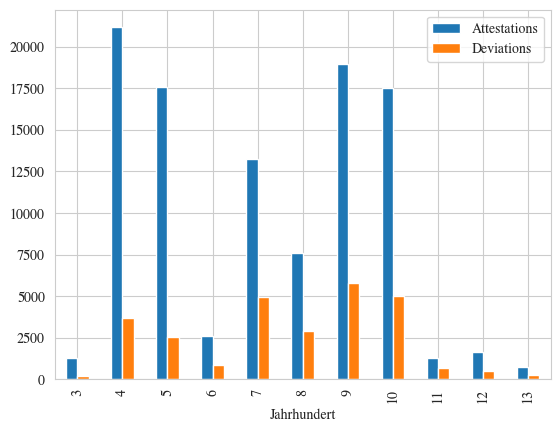

In [54]:
dates_by_century = lambda df: (df.dropna(subset={"date_approximate"})["date_approximate"].rename("Jahrhundert") / 100).apply(math.ceil).value_counts()
pd.DataFrame({"Attestations": dates_by_century(df_simple), "Deviations": dates_by_century(df_diff)}).plot.bar()
write_figure("attestations_deviations")

And if we scale down the amount of deviations by the total amount of attestations, we get the total frequency of orthographic deviations across the centuries. We might see a rising trend.

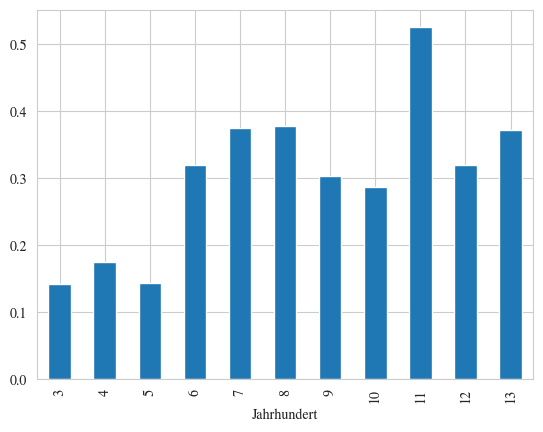

In [55]:
(dates_by_century(df_diff) / dates_by_century(df_simple)).plot.bar()
write_figure("attestations_by_deviations")


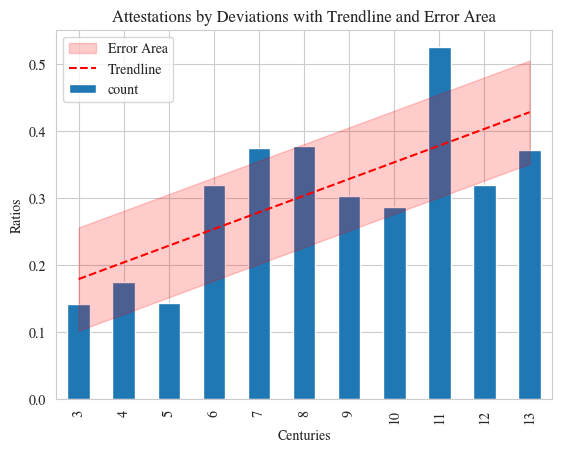

In [201]:
ratios = dates_by_century(df_diff) / dates_by_century(df_simple)

ax = ratios.plot.bar()

# Calculate the trendline
x = np.arange(len(ratios))  # x values (0, 1, 2, ...)
y = ratios.values  # y values (the ratios)
z = np.polyfit(x, y, 1)  # Fit a linear polynomial (degree 1)
p = np.poly1d(z)  # Create a polynomial function

# Calculate the trendline values
trendline = p(x)

# Calculate residuals and standard error
residuals = y - trendline
std_error = np.std(residuals)

# Create the shaded area (error area)
plt.fill_between(x, trendline - std_error, trendline + std_error, color='red', alpha=0.2, label='Error Area')

# Plot the trendline
plt.plot(x, trendline, color='red', linestyle='--', label='Trendline')

# Add labels and title
plt.xlabel('Centuries')
plt.ylabel('Ratios')
plt.title('Attestations by Deviations with Trendline and Error Area')
plt.legend()

# Save the figure
plt.savefig("attestations_by_deviations.png")
plt.show()


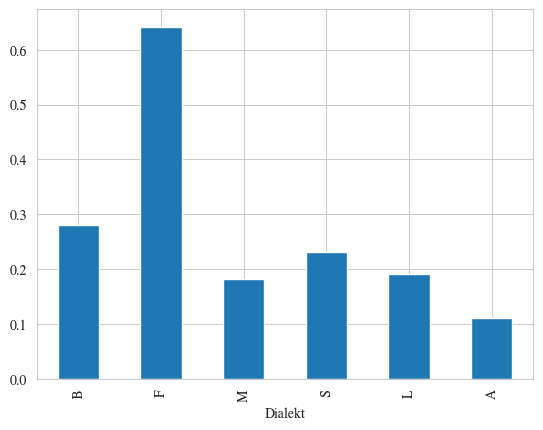

In [57]:
(df_diff["dialect_group"].rename("Dialekt").value_counts() / df_simple["dialect_group"].rename("Dialekt").value_counts()).sort_index().plot.bar()
write_figure("deviations_by_dialect")

### Statistical Prerequisites: Regularity

We define the *regularity* of an orthographic deviation to be its absolute frequency (how often it did appear) divided by the frequency with which the input appears in all Greek lemmata (how often it *could* appear).

Note that the *regularity* of an insertion is undefined. We cannot count the frequency of its input, i.e. the empty string.

In [58]:
df_diff["deviation"] = df_diff["norm"] + "→" + df_diff["var"]

## (De-)Gemination

Since we earlier managed to identify geminations and degeminations, we can now look at how they are distributed in the data.

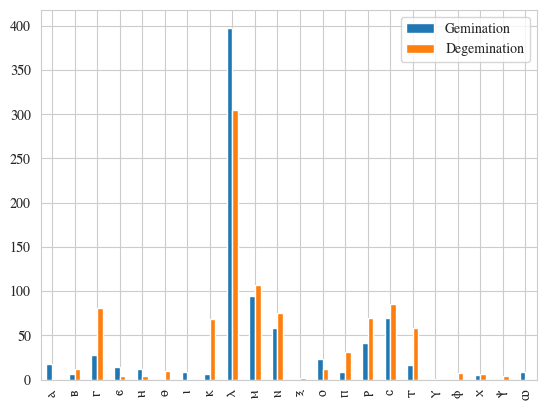

In [59]:
geminations = df_diff[(df_diff["norm"] * 2 == df_diff["var"])]
degeminations = df_diff[(df_diff["norm"] == df_diff["var"] * 2)]

interesting = vowels | consonants

geminate_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x * 2).sum() for x in interesting})

gemination_occurrences = geminations[geminations["norm"].isin(interesting)]["norm"].value_counts()
degemination_occurrences = degeminations[degeminations["var"].isin(interesting)]["var"].value_counts()

pd.DataFrame({
    "Gemination": gemination_occurrences,
    "Degemination": degemination_occurrences,
}).plot.bar()
write_figure("gemination_degemination")

<Axes: >

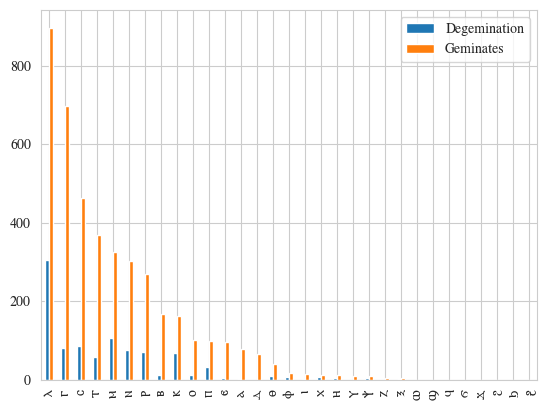

In [60]:
pd.DataFrame({
    "Degemination": degemination_occurrences,
    "Geminates": geminate_occurrences,
}).sort_values(by="Geminates", ascending=False).plot.bar()

<Axes: >

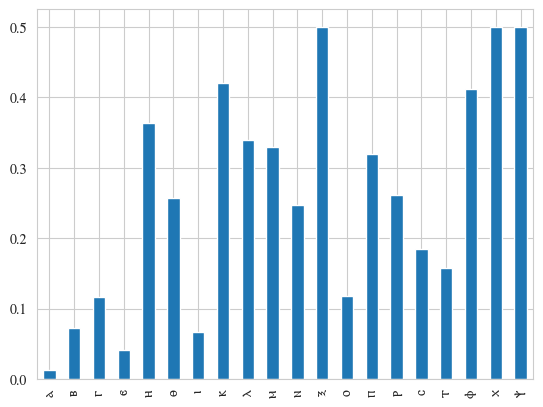

In [61]:
degemination_rate = degemination_occurrences.div(geminate_occurrences)

degemination_rate[degemination_rate > 0].sort_index().plot.bar()

In [62]:
x_gem = geminations[geminations["norm"].isin(interesting)]
x_deg = degeminations[degeminations["var"].isin(interesting)]

x_gem_deg = pd.concat([x_gem, x_deg])

pd.crosstab(x_gem_deg["deviation"], x_gem_deg["dialect_group"]).sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)

dialect_group,B,F,M,S,L,A
deviation,,,,,,
ⲗ→ⲗⲗ,21,20,4,347,4,2
ⲗⲗ→ⲗ,11,20,4,263,5,2
ⲙⲙ→ⲙ,2,8,0,91,5,1
ⲥⲥ→ⲥ,3,0,1,79,1,1
ⲅⲅ→ⲅ,0,0,0,78,3,0
ⲛⲛ→ⲛ,0,5,2,64,0,4
ⲥ→ⲥⲥ,13,0,2,52,3,0
ⲛ→ⲛⲛ,5,0,0,49,4,0
ⲕⲕ→ⲕ,0,20,0,48,0,0


In [63]:
df_diff[(df_diff["greek_lemma"] == "ⲙⲉⲛ") & (df_diff["var"] == "ⲙⲙ")]["dialect_group"].value_counts()

dialect_group
L    22
B     0
F     0
M     0
S     0
A     0
Name: count, dtype: int64

## Comparing Deviations

In the following, we want to find out which deviations are the most frequent, which are the most consistent, and at which time they are most prominent.

### Vocalic Deviations
Many of the most frequent deviations affect vocalic graphemes, with many vocalic graphemes recurring throughout multiple deviations.
We might therefore want to show a "confusion matrix" with the vocalic graphemes as rows and columns, and the regularity of their specific deviation in the matrix entries.

In [64]:
df_diff_vocalic = df_diff[df_diff["norm"].isin(vowels | diphthongs) & df_diff["var"].isin(vowels | diphthongs)]
vowel_frequency_data = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"])

# Get the unique indices and columns
unique_labels = list(set(vowel_frequency_data.index).union(set(vowel_frequency_data.columns)))

# Create a new DataFrame with the unique labels as both index and columns
vowel_frequency = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

# Update the new DataFrame with the values from the original crosstab
vowel_frequency.update(vowel_frequency_data)

# Now you can write the square crosstab to your table
write_table(vowel_frequency, "vowel_frequency", heatmap=True, caption="Abweichungen bei vokalischen Graphemen: Häufigkeit")
vowel_frequency.style.background_gradient(axis=None, cmap=cm)


,ⲏⲩ,ⲉⲓ,ⲟ,ⲉ,ⲏⲓ,ⲱ,ⲏ,ⲁⲩ,ⲉⲩ,ⲩ,ⲱⲓ,ⲟⲓ,ⲁ,ⲁⲓ,ⲓ,ⲟⲩ,ⲩⲓ
ⲏⲩ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
ⲉⲓ,0,0,0,130,0,1,73,0,0,25,0,14,22,8,4784,0,0
ⲟ,0,4,0,115,0,1953,45,0,2,8,0,38,179,0,40,290,0
ⲉ,0,100,18,0,0,4,379,0,3,318,0,8,96,141,253,2,0
ⲏⲓ,0,0,0,2,0,0,68,0,0,6,0,0,0,0,19,0,0
ⲱ,0,0,905,5,0,0,5,0,5,0,1,0,45,0,1,54,0
ⲏ,12,71,18,900,4,10,0,1,5,1080,0,30,70,7,607,7,0
ⲁⲩ,0,0,0,0,0,1,0,0,1,2,0,0,6,0,0,0,0
ⲉⲩ,6,0,5,39,0,3,9,2,0,7,0,1,3,7,4,7,0
ⲩ,1,7,27,314,0,6,527,0,4,0,0,10,26,9,239,29,0


In [65]:
vowel_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs})

In [66]:
# Make a copy to avoid modifying original
norm_confusion = vowel_frequency.copy()

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in vowel_occurrences:
        total = vowel_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

/tmp/ipykernel_742512/969087427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01615508885298869' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_742512/969087427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.00012426991425375916' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_742512/969087427.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.009071703740524418' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] 

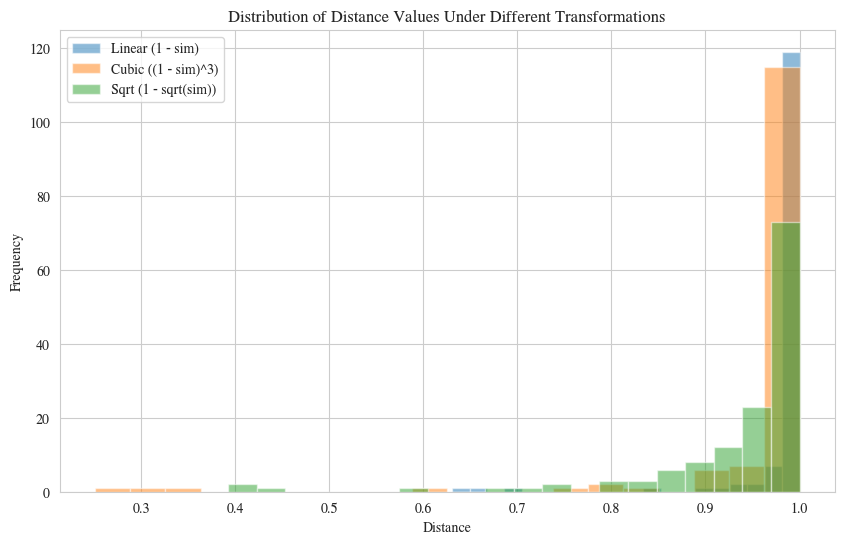

In [123]:
import matplotlib.pyplot as plt
import numpy as np

sim_matrix = sym_norm_confusion

# Flatten upper triangle of distance matrix, excluding diagonal
def get_dist_values(dist_matrix):
    mask = np.triu(np.ones(dist_matrix.shape), k=1).astype(bool)
    return dist_matrix.values[mask]

# Compare different transformations
methods = {
    "Linear (1 - sim)": 1 - sim_matrix,
    "Cubic ((1 - sim)^3)": (1 - sim_matrix) ** 3,
    #"Log (-log(sim))": -np.log(sim_matrix + 1e-6),
    "Sqrt (1 - sqrt(sim))": 1 - np.sqrt(sim_matrix)
}

plt.figure(figsize=(10, 6))
for label, mat in methods.items():
    vals = get_dist_values(mat)
    plt.hist(vals, bins=20, alpha=0.5, label=label)

plt.legend()
plt.title("Distribution of Distance Values Under Different Transformations")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()


In [124]:
#distance_matrix = 1 - sym_norm_confusion.values
#distance_matrix = -np.log(sym_norm_confusion.values + 0.001)
#distance_matrix = (1 - sym_norm_confusion.values) ** 3
distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix


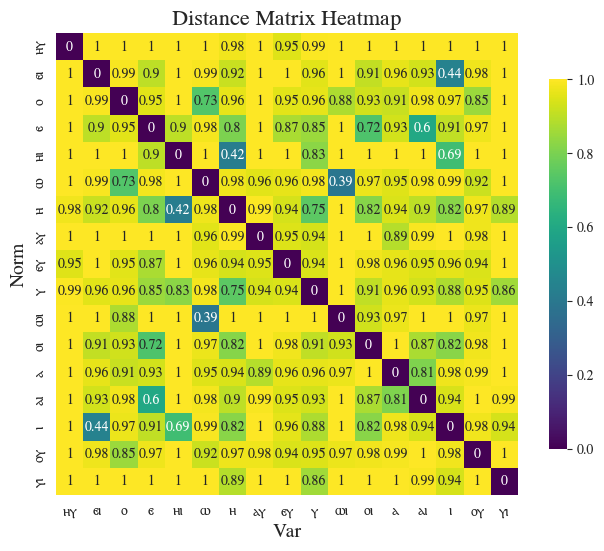

In [125]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

/tmp/ipykernel_742512/3096992990.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


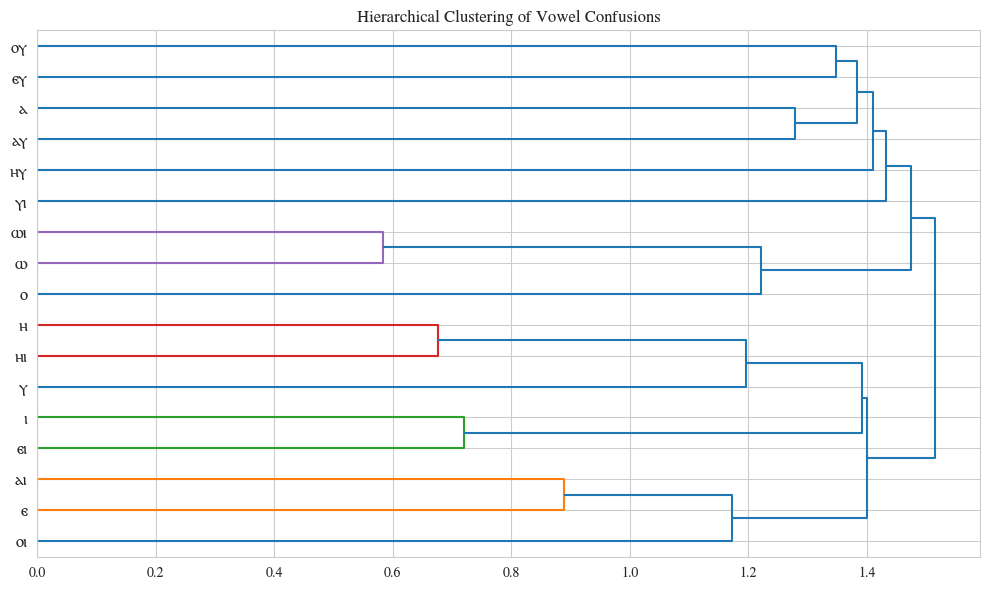

In [126]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Vowel Confusions")
plt.tight_layout()
plt.show()


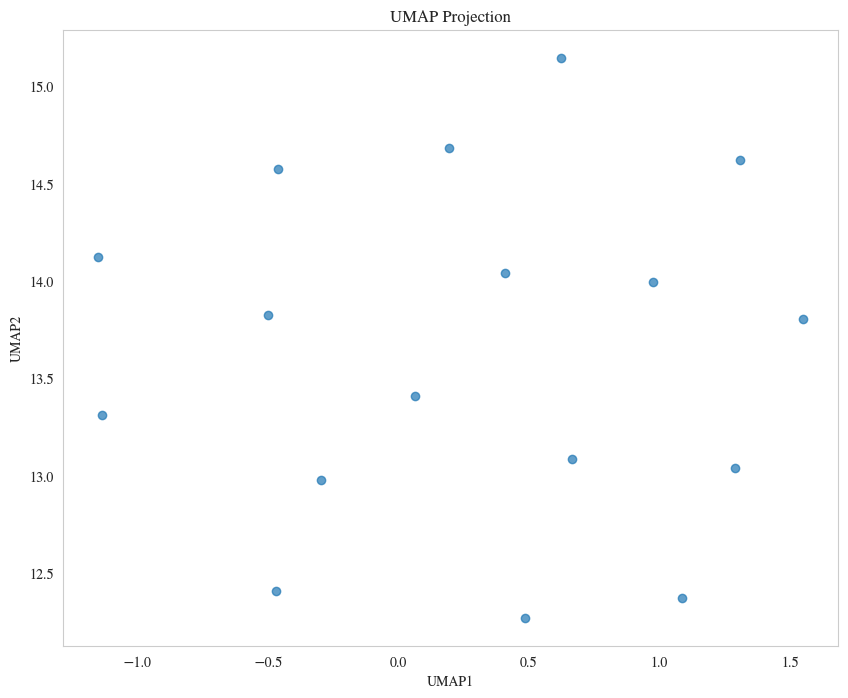

In [121]:
umap_df = pd.DataFrame(umap_coords, columns=['UMAP1', 'UMAP2'])

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(umap_df['UMAP1'], umap_df['UMAP2'], alpha=0.7)
plt.title('UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid()
plt.show()


In [122]:
vowel_regularity = 100 * vowel_frequency.div(vowel_occurrences, axis="rows").fillna(0)
#vowel_regularity = vowel_regularity.loc[vowel_regularity.any(axis=1), vowel_regularity.any(axis=0)]
write_table(vowel_regularity, "vowel_regularity", heatmap=True, caption="Abweichungen bei vokalischen Graphemen: Regelmäßigkeit")
vowel_regularity.style.background_gradient(axis=None, cmap=cm)

,ⲏⲩ,ⲉⲓ,ⲟ,ⲉ,ⲏⲓ,ⲱ,ⲏ,ⲁⲩ,ⲉⲩ,ⲩ,ⲱⲓ,ⲟⲓ,ⲁ,ⲁⲓ,ⲓ,ⲟⲩ,ⲩⲓ
ⲁ,"0,0","0,0","0,9","0,5","0,0","0,0","0,1","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,1","0,0","0,0"
ⲁⲓ,"0,0","0,8","0,1","31,8","0,0","0,1","1,9","0,0","0,0","0,9","0,0","0,3","7,5","0,0","0,6","0,0","0,0"
ⲁⲩ,"0,0","0,0","0,0","0,0","0,0","0,4","0,0","0,0","0,4","0,8","0,0","0,0","2,4","0,0","0,0","0,0","0,0"
ⲉ,"0,0","0,4","0,1","0,0","0,0","0,0","1,5","0,0","0,0","1,3","0,0","0,0","0,4","0,6","1,0","0,0","0,0"
ⲉⲓ,"0,0","0,0","0,0","1,6","0,0","0,0","0,9","0,0","0,0","0,3","0,0","0,2","0,3","0,1","59,5","0,0","0,0"
ⲉⲩ,"0,5","0,0","0,4","3,3","0,0","0,3","0,8","0,2","0,0","0,6","0,0","0,1","0,3","0,6","0,3","0,6","0,0"
ⲏ,"0,1","0,5","0,1","6,2","0,0","0,1","0,0","0,0","0,0","7,4","0,0","0,2","0,5","0,0","4,2","0,0","0,0"
ⲏⲓ,"0,0","0,0","0,0","2,0","0,0","0,0","67,3","0,0","0,0","5,9","0,0","0,0","0,0","0,0","18,8","0,0","0,0"
ⲏⲩ,"0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0","0,0"
ⲓ,"0,0","2,3","0,1","0,8","0,0","0,0","2,2","0,0","0,0","0,5","0,0","0,0","0,0","0,1","0,0","0,0","0,0"


In [ ]:
vowel_regularity.shape

In [ ]:
vowel_distances = 1 - (vowel_regularity / 100)
np.fill_diagonal(vowel_distances.values, 0)
plt.figure(figsize=(8, 6))
sns.heatmap(vowel_distances, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform hierarchical clustering
linked = linkage(vowel_distances, method='complete')

# Create a dendrogram
plt.figure(figsize=(8, 6))
dendrogram(linked, labels=vowel_distances.index, orientation='top', distance_sort='descending', show_leaf_counts=True)

# Add titles and labels
plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
plt.xlabel('Points', fontsize=14)
plt.ylabel('Distance', fontsize=14)

# Show the plot
plt.show()

In [ ]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=2)
tsne_result = tsne.fit_transform(vowel_distances)

# Create a DataFrame for t-SNE results
df_tsne = pd.DataFrame(data=tsne_result, columns=['tSNE1', 'tSNE2'], index=vowel_distances.index)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne['tSNE1'], df_tsne['tSNE2'], marker='o')

# Annotate points
for i, txt in enumerate(df_tsne.index):
    plt.annotate(txt, (df_tsne['tSNE1'][i], df_tsne['tSNE2'][i]), fontsize=12)

# Add titles and labels
plt.title('t-SNE Result', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=14)
plt.ylabel('t-SNE Dimension 2', fontsize=14)
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
deviation_frequency = pd.crosstab(df_diff_vocalic["deviation"], df_diff_vocalic["dialect_group"])
vowel_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["dialect_group"] == d]["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs} for d in dialects})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    return row.div(vowel_occurrence_by_dialect.loc[norm])

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by="S", ascending=False).style.background_gradient(axis=None, cmap=cm)

In [ ]:
deviation_frequency.sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)

In [ ]:
all_vowel_regularities = pd.DataFrame(vowel_regularity.stack()).reset_index().rename(columns={"level_0": "norm", "norm": "var", 0: "regularity"})
all_vowel_frequencies = pd.DataFrame(vowel_frequency.stack()).reset_index().rename(columns={0: "frequency"})
vowel_deviations = pd.merge(all_vowel_regularities, all_vowel_frequencies, on=["norm", "var"])
write_csv(vowel_deviations, "deviations-vowels")

In [ ]:
fig = plt.figure(figsize=(10, 6))

graph = nx.from_pandas_edgelist(
    vowel_deviations[vowel_deviations["frequency"] >= 20],
    source="norm",
    target="var",
    edge_attr=["regularity", "frequency"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, weight="frequency", seed=6)

nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(v) for v in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)

fig.savefig(subdirectory / "figure-vowels_graph.pdf")
plt.show()

In [ ]:
vowel_dates = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"], values=df_diff_vocalic["date_approximate"], aggfunc="median")

dates, frequencies = vowel_dates.align(vowel_frequency, fill_value=np.nan)
vowel_dates = pd.DataFrame(
    np.vectorize(lambda date, frequency: date if frequency >= 5 else np.nan)(dates, frequencies), 
    index=dates.index,
    columns=dates.columns
)
vowel_dates = vowel_dates.loc[vowel_dates.any(axis=1), vowel_dates.any(axis=0)]
write_table(vowel_dates, "vowel_dates", heatmap=True, as_ints=True, caption="Abweichungen bei vokalischen Graphemen: Median-Belegdatum")
vowel_dates.style.background_gradient(axis=None, cmap=cm)

In [ ]:
deviation_frequency = pd.crosstab(df_diff_vocalic["deviation"], df_diff_vocalic["date_approximate"] // 100)
vowel_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["date_approximate"] // 100 == d]["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs} for d in range(15)})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    return row.div(vowel_occurrence_by_dialect.loc[norm])

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by=7, ascending=False).style.background_gradient(axis=None, cmap=cm)

### Consonantal Deviations

In [212]:
df_diff_consonantal = df_diff[df_diff["norm"].isin(consonants) & df_diff["var"].isin(consonants)]
consonant_frequency = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"])
consonant_frequency = consonant_frequency.loc[consonant_frequency.any(axis=1), consonant_frequency.any(axis=0)]
write_table(consonant_frequency, "consonant_frequency", heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Häufigkeit")
consonant_frequency.style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
norm,,,,,,,,,,,,,,,,,,,,,,,
ϩ,69,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
ⲃ,0,22,0,0,0,0,0,0,0,0,1,0,16,1,0,30,0,0,0,0,0,0,0
ⲅ,0,0,1,0,15,0,0,0,2,0,801,2,2,212,0,1,3,0,2,2,3,0,0
ⲇ,0,0,0,8,0,1,1,0,0,0,0,0,0,13,0,0,0,6,1465,0,1,0,0
ⲍ,0,0,0,0,0,0,0,4,0,0,0,0,0,0,6,0,0,148,3,0,0,1,0
ⲑ,0,0,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,1,31,0,1,0,0
ⲕ,0,0,2,0,189,0,478,0,1,0,0,3,0,2,9,6,6,0,1,0,44,0,0
ⲗ,0,0,0,0,0,0,1,0,1,0,2,0,0,13,0,0,88,0,2,0,0,0,0
ⲙ,0,0,0,0,0,11,0,1,0,3,1,1,0,118,0,6,0,1,7,0,0,0,0


In [213]:
consonant_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in consonants})


In [214]:
# Make a copy to avoid modifying original
norm_confusion = consonant_frequency.copy()

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in consonant_occurrences:
        total = consonant_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

/tmp/ipykernel_742512/3022419781.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.01763803680981595' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_742512/3022419781.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0023006134969325155' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total
/tmp/ipykernel_742512/3022419781.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0002556237218813906' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  norm_confusion.loc[graphem

In [233]:
#distance_matrix = 1 - sym_norm_confusion.values
#distance_matrix = -np.log(sym_norm_confusion.values + 0.001)
#distance_matrix = (1 - sym_norm_confusion.values) ** 3
distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)
distance_matrix[np.isnan(distance_matrix)] = 1

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix

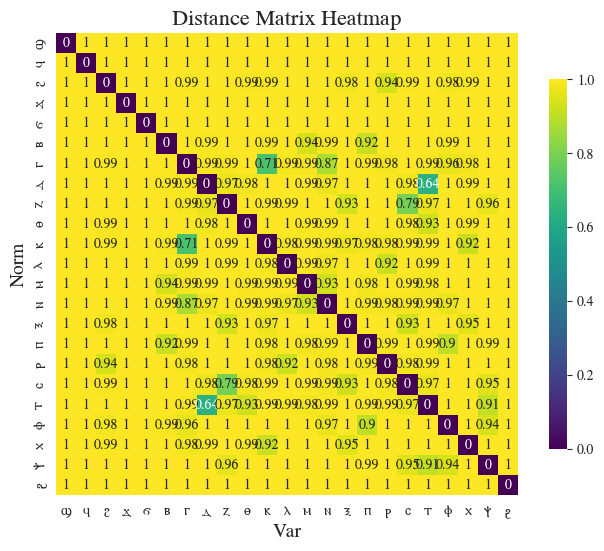

In [234]:
plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

/tmp/ipykernel_742512/980419654.py:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


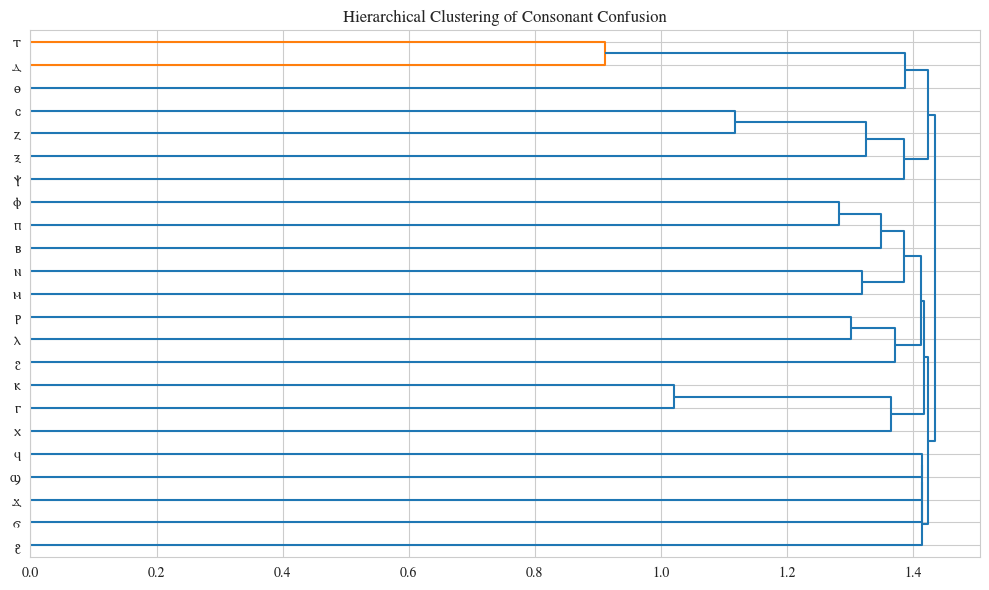

In [235]:
from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Consonant Confusion")
plt.tight_layout()
plt.show()

In [ ]:
consonant_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x).sum() for x in consonants})
consonant_regularity = 100 * consonant_frequency.div(consonant_occurrences, axis="rows").fillna(0)
consonant_regularity = consonant_regularity.loc[consonant_regularity.any(axis=1), consonant_regularity.any(axis=0)]
write_table(consonant_regularity, "consonant_regularity", heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Regelmäßigkeit")
consonant_regularity.style.background_gradient(axis=None, cmap=cm)

In [ ]:
deviation_frequency = pd.crosstab(df_diff_consonantal["deviation"], df_diff_consonantal["dialect_group"])
consonant_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["dialect_group"] == d]["greek_lemma"].str.count(x).sum() for x in consonants} for d in dialects})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    occurrence = consonant_occurrence_by_dialect.loc[norm]
    return row.div(occurrence)

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by="S", ascending=False).style.background_gradient(axis=None, cmap=cm)

In [ ]:
deviation_frequency.sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)

In [ ]:
all_consonant_regularities = pd.DataFrame(consonant_regularity.stack()).reset_index().rename(columns={"level_0": "norm", "norm": "var", 0: "regularity"})
all_consonant_frequencies  = pd.DataFrame(consonant_frequency.stack()).reset_index().rename(columns={0: "frequency"})
consonant_deviations = pd.merge(all_consonant_regularities, all_consonant_frequencies, on=["norm", "var"])
write_csv(consonant_deviations, "deviations-consonants")

In [ ]:
graph = nx.from_pandas_edgelist(
    consonant_deviations[consonant_deviations["frequency"] >= 20],
    source="norm",
    target="var",
    edge_attr=["frequency", "regularity"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, k=2.2, weight="frequency", seed=342)

fig = plt.figure(figsize=(10, 6))
nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(r) for r in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)
fig.savefig(subdirectory / "figure-consonants_graph.pdf")
plt.show()

In [ ]:
consonant_dates = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"], values=df_diff_consonantal["date_approximate"], aggfunc="median")

dates, frequencies = consonant_dates.align(consonant_frequency, fill_value=np.nan)
consonant_dates = pd.DataFrame(
    np.vectorize(lambda date, frequency: date if frequency >= 5 else np.nan)(dates, frequencies), 
    index=dates.index,
    columns=dates.columns
)
consonant_dates = consonant_dates.loc[consonant_dates.any(axis=1), consonant_dates.any(axis=0)]
write_table(consonant_dates, "consonant_dates", as_ints=True, heatmap=True, caption="Abweichungen bei konsonantischen Graphemen: Median-Belegdatum")
consonant_dates.style.background_gradient(axis=None, cmap=cm)

In [ ]:
deviation_frequency = pd.crosstab(df_diff_consonantal["deviation"], df_diff_consonantal["date_approximate"] // 100)
consonant_occurrence_by_dialect = pd.DataFrame({d: {x: df_diff[df_diff["date_approximate"] // 100 == d]["greek_lemma"].str.count(x).sum() for x in consonants} for d in range(15)})

def normalize_rows(row):
    norm = row.name.split("→")[0]
    return row.div(consonant_occurrence_by_dialect.loc[norm])

(100 * deviation_frequency.apply(normalize_rows, axis=1)).sort_values(by=7, ascending=False).style.background_gradient(axis=None, cmap=cm)
#.head(10).transpose().plot.line()

# Playground

In [ ]:
df_simple

In [ ]:
vowel = ("ⲁ", "ⲉ", "ⲓ", "ⲟ", "ⲩ", "ⲏ", "ⲱ")
vowel_or_spiritus = tuple([*vowel, *map(lambda x: "ϩ" + x, vowel)])

def square_crosstab(x, y):
    df = pd.crosstab(x, y)
    i = df.index.union(df.columns)
    return df.reindex(index=i, columns=i, fill_value=0)


#vocalic_initial.groupby("dialect").transform(lambda rows: chi2_p(pd.crosstab(rows["greek_h"], rows["coptic_h"])))

vocalic_initial = df_simple[df_simple["greek_lemma"].str.startswith(vowel_or_spiritus) & df_simple["orthography_clean"].str.startswith(vowel_or_spiritus)]

# Add greek_h and coptic_h columns
vocalic_initial = vocalic_initial.assign(
    greek_h=vocalic_initial["greek_lemma"].str.startswith("ϩ"),
    coptic_h=vocalic_initial["orthography_clean"].str.startswith("ϩ")
)

# chi2_p function to calculate chi-square test and association
chi2_p = lambda contingency: (scipy.stats.chi2_contingency(contingency), scipy.stats.contingency.association(contingency))

# Apply the chi2_p function to grouped data
result = vocalic_initial.groupby("dialect_group").apply(lambda group: contingency_statistics(square_crosstab(group["greek_h"], group["coptic_h"])))

pd.DataFrame(result.tolist(), index=result.index).sort_values(by="V")

In [ ]:
vocalic_initial = vocalic_initial[vocalic_initial["dialect_group"].isin({"B", "S", "F"})]

# Step 1: Calculate century and filter by dialect "B"
vocalic_initial["century"] = (vocalic_initial["date_approximate"] // 100)

# Step 2: Group by both "century" and "dialect"
grouped = vocalic_initial.groupby(["century", "dialect_group"]).apply(
    lambda group: contingency_statistics(pd.crosstab(group["greek_h"], group["coptic_h"]))
)

In [ ]:
grouped

In [ ]:
result_df = pd.DataFrame(grouped.tolist(), index=grouped.index)

result_unstacked = result_df.unstack(level="dialect_group")

result_unstacked.plot(kind='bar', y="V", subplots=True, layout=(1,3), figsize=(15, 5), title="Contingency Statistics by Century and Dialect")
plt.xlabel("Century")
plt.ylabel("V")
plt.tight_layout()
plt.show()


In [ ]:
pattern = re.compile(r"[ⲁⲉⲓⲟⲩⲏⲱ]+")

# Function to find the first match
def find_first_vowel(text):
    match = pattern.search(text)
    return match.group(0) if match else None

vocalic_initial["initial_vowel"] = vocalic_initial["greek_lemma"].apply(find_first_vowel)

result = vocalic_initial.groupby("initial_vowel").apply(lambda group: contingency_statistics(pd.crosstab(group["greek_h"], group["coptic_h"])))

pd.DataFrame(result.tolist(), index=result.index).sort_values(by="V", ascending=False)

In [ ]:
w = vocalic_initial[vocalic_initial["initial_vowel"] == "ⲏ"]
pd.crosstab(w["greek_h"], w["coptic_h"])

In [ ]:
df_diff[(df_diff["norm"] == "ⲁⲓ") & (df_diff["var"] == "ⲟ")]

In [ ]:
df_diff[(df_diff["greek_lemma"] == "ⲕⲟⲗⲗⲩⲣⲓⲟⲛ")].sample(10)

In [ ]:
pd.DataFrame(
    list(get_required_edits("ⲁⲣⲉⲧⲏ", "ⲁⲣⲏⲧⲉ"))
    + list(get_required_edits("ϩⲩⲡⲟⲙⲉⲛⲱ", "ϩⲩⲡⲟⲙⲓⲛⲉ"))
)

In [ ]:
df_simple = df_simple[df_simple["greek_lemma"].str.len() > 0]

greek_lemma_counts = df_simple["greek_lemma"].value_counts()
#print(df_diff) #.groupby("greek_lemma")[["norm", "var"]].apply((lambda x: x["norm"] + ">" + x["var"]), axis=1)

greek_lemma_unique_variants = df_simple.groupby('greek_lemma')['orthography_clean'].nunique()

combined_data = pd.merge(greek_lemma_counts, greek_lemma_unique_variants, on="greek_lemma")

sns.regplot(x="count", y="orthography_clean", data=combined_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Relationship between Frequency of Greek Lemma and Number of Unique Variants')
plt.xlabel('Frequency of Greek Lemma')
plt.xscale("log")
plt.ylabel('Number of Unique Variants')
plt.grid(True)
plt.ylim(0, 50)


In [ ]:
unique_by_orthography = df_diff

deletions = unique_by_orthography[(unique_by_orthography["var"] == "∅") & (unique_by_orthography["context_left"] != "#") & (unique_by_orthography["context_left"] != "#")]
insertions = unique_by_orthography[(unique_by_orthography["norm"] == "∅") & (unique_by_orthography["context_left"] != "#") & (unique_by_orthography["context_left"] != "#")]

interesting = (vowels | diphthongs | consonants) - {"ϩ", "ⲥ", "ⲣ"}

pd.DataFrame({
    "Deletion": deletions[deletions["norm"].isin(interesting)]["norm"].value_counts(),
    "Insertion": insertions[insertions["var"].isin(interesting)]["var"].value_counts()
}).sort_values("Deletion", ascending=False).plot.bar(logy=False)

In [ ]:
interesting_insertions = insertions[insertions["var"].isin(interesting)]
pd.crosstab(interesting_insertions["var"], interesting_insertions["date_approximate"] // 100).style.background_gradient(axis=None, cmap=cm)

In [ ]:
insertions[insertions["var"].isin(vowels)]["date_approximate"].hist()

In [ ]:
df_diff[(df_diff["norm"] == "ⲯ") & (df_diff["var"] == "ⲧ")]

In [ ]:
date_per_lemma = df_diff.groupby("greek_lemma")["date_approximate"].min()
deviations_per_lemma = df_diff["greek_lemma"].value_counts()
attestations_per_lemma = df_simple["greek_lemma"].value_counts()

per_lemma = pd.DataFrame({
    "date": date_per_lemma,
    "deviations": deviations_per_lemma,
    "attestations": attestations_per_lemma
}).dropna()

per_lemma["deviation_rate"] = per_lemma["deviations"].div(per_lemma["attestations"])

In [ ]:
import seaborn as sns
sns.regplot(x="date", y="deviation_rate", data=per_lemma, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})

In [ ]:
import math
interesting = vowels | diphthongs | consonants | {"∅"}

sound_frequency = {x: df_diff["greek_lemma"].str.count(x).sum() for x in interesting}
def func(group): 
    norm = group["norm"].unique()[0]
    if sound_frequency[norm] == 0:
        return 0.01
    else:
        return group.shape[0] / sound_frequency[norm]

sounds_affected = df_diff[df_diff["norm"].isin(interesting)].groupby("deviation").apply(func)
words_affected = df_diff.groupby("deviation")["greek_lemma"].unique().apply(len)#.apply(math.log10)
absolute_frequency = df_diff.groupby("deviation")["deviation"].apply(len)
relative_frequency_df = pd.DataFrame(words_affected.rename("Word rate")).join(sounds_affected.rename("Sound rate")).join(absolute_frequency.rename("Absolute frequency"))
relative_frequency_df["Word spread"] = relative_frequency_df["Word rate"].div(relative_frequency_df["Absolute frequency"])
relative_frequency_df["Score"] = relative_frequency_df["Word rate"].mul(relative_frequency_df["Sound rate"])

In [ ]:
morphological_lapsus = {"∅→ⲥ", "∅→ⲓ", "∅→", "∅→", "∅→ⲏ", "∅→ⲕ", "∅→ⲧ", "∅→ⲡ", "∅→ⲣ", "∅→ⲟⲥ", "∅→ⲟⲩ", "ⲏ→ⲁ"}
relative_frequency_df = relative_frequency_df[~relative_frequency_df.index.isin(morphological_lapsus)]

def classify(deviation):
    norm, var = deviation.split("→")
    operates_in = lambda graphemes: norm in graphemes and var in graphemes
    if operates_in({"ⲧ", "ⲇ"}) or operates_in({"ⲕ", "ⲅ"}) or operates_in({"ⲃ", "ⲡ"}) or operates_in({"ⲥ", "ⲍ"}):
        return "voiced_voiceless"
    elif operates_in({"ⲗ", "ⲣ"}):
        return "lambdacism"
    elif operates_in({"ⲧ", "ⲑ"}) or operates_in({"ⲫ", "ⲡ"}) or operates_in({"ⲭ", "ⲕ"}) or operates_in({"∅", "ϩ"}):
        return "aspiration"
    elif operates_in({"ⲁⲓ", "ⲟⲓ", "ⲉ"}) or operates_in({"ⲁⲓ", "ⲁ"}) or operates_in({"ⲱ", "ⲱⲓ"}) or operates_in({"ⲏⲓ", "ⲏ"}) or operates_in({"ⲏⲓ", "ⲓ"}) or operates_in({"ⲩⲓ", "ⲩ"}):
        return "monophthongization"
    elif operates_in({"ⲟ", "ⲱ", "ⲟⲩ", "ⲱⲓ"}) or operates_in({"ⲁ", "ⲟ"}): # ôi ~ ô already attributed to monophthongisation
        return "back_vowel"
    elif operates_in({"ⲏ", "ⲉ", "ⲩ", "ⲉⲓ", "ⲓ", "ⲟⲓ", "ⲁⲓ"}) or operates_in({"ⲁ", "ⲉ"}): # ai/oi ~ e already attributed to monophthongisation
        return "front_vowel"
    elif operates_in({"ⲛ", "∅"}) or operates_in({"ⲙ", "∅"}) or operates_in({"ⲅ", "ⲛ"}):
        return "nasal"
    elif operates_in({"ⲕ", "ϭ"}) or operates_in({"ϩ", "ϣ"}) or operates_in({"ⲭ", "ϫ"}):
        return "palatalisation"
    elif norm == 2 * var or var == 2 * norm:
        return "gemination"
    elif operates_in({"ⲉ", "∅"}) or operates_in({"ⲓ", "∅"}) or operates_in({"ⲁ", "∅"}) or operates_in({"ⲟ", "∅"}) or operates_in({"ⲩ", "∅"}):
        return "epenthesis"
    elif deviation == "ⲟ→ⲉ":
        return "reduction"
    elif operates_in({"ϥ", "ⲃ"}):
        return "spirantisation"

relative_frequency_df["class"] = relative_frequency_df.index.map(classify)

In [ ]:
relative_frequency_df[relative_frequency_df["class"].isnull()].sort_values(by="Score", ascending=False).head(50)

In [ ]:
relative_frequency_df[~relative_frequency_df["class"].isnull()].sort_values(by="Score", ascending=False)#["class"]#.value_counts()